In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy')
Q_real = np.load('./Q_15minutes.npy')
f_real = Q_real[:,1]
v_real = Q_real[:,3]
pi_real = np.load('./pitilde_15minutes.npy')

Text(0, 0.5, 'Remaining Trip Distance (miles)')

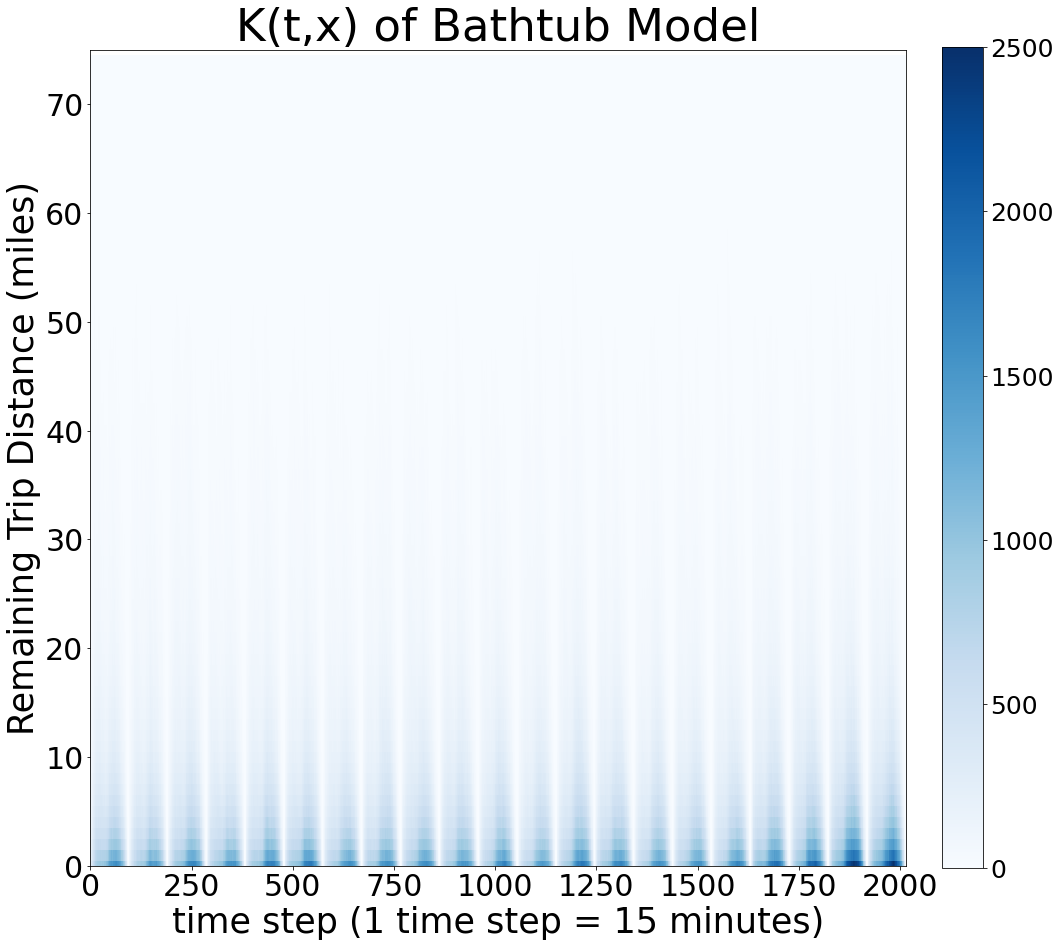

In [3]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [4]:
## Scale
N_timestep = 24*21*4
N_diststep = 75
Size_diststep = 1 # unit: miles
N_trainingdays = 0
N_training = 24*4*N_trainingdays


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]                   # 150 points with 15 mile (distance step)
t = np.arange(0,N_timestep)[:,None]              # 2016 points with 15 minutes (time step) 
usol = K_real.transpose() [:,N_training:]                  # solution of 10 * 2016 grid points 15 miles (distance step)
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [5]:
Size_diststep = 1 # unit: miles
Size_timestep = 2 # 2: 30min, 3: 60min
size_input = int(N_diststep/Size_diststep)*int(N_timestep/Size_timestep) # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  75600
N_u =  15120
N_f =  30240


In [6]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [7]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data*

The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [8]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1234)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [9]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [10]:
X_u_train.shape

(15120, 2)

In [11]:
X_u_test.shape

(60480, 2)

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [12]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u
    
    def loss(self,x,y):

        loss_u = self.loss_BC(x,y)

        loss = loss_u

        return loss, loss_u
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u= self.loss(X_u_train, u_train)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u = self.loss(X_u_train, u_train)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        
        tf.print(loss_value, loss_u, error_vec)

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [13]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.0055450678516834355 0.0055450678516834355 0.8190199013196025
0.0050095188720037419 0.0050095188720037419 0.7788027580928175
0.0047235628959959594 0.0047235628959959594 0.754487790405964
0.0047113823073021309 0.0047113823073021309 0.7534146686773341
0.0046688773547709879 0.0046688773547709879 0.7497639350506953
0.0046263516105587285 0.0046263516105587285 0.7461661311072117
0.0044508616093782193 0.0044508616093782193 0.7317007354130141
0.0042530782983198605 0.0042530782983198605 0.7156443868633686
0.0041432751973508779 0.0041432751973508779 0.7065856332954465
0.0038464461599733274 0.0038464461599733274 0.6814837630182027
0.0037520653526185704 0.0037520653526185704 0.6741780200272246
0.0036851869706009143 0.0036851869706009143 0.6682708443901292
0.003672002080059771 0.003672002080059771 0.6672150340053343
0.0036341490481138212 0.0036341490481138212 0.6641680412952642
0.003587804597698425 0.003587804597698425 0.6604559789031709
0.003566743068505138 0.003566743068505138 0.6586911271983383

0.0015666361964436467 0.0015666361964436467 0.438358413788737
0.0015661531451734542 0.0015661531451734542 0.4381088923102814
0.001565581137479091 0.001565581137479091 0.4380737912544309
0.0015654502423072768 0.0015654502423072768 0.43798313571582215
0.0015653054459539865 0.0015653054459539865 0.4377686554535931
0.0015651760597726388 0.0015651760597726388 0.43773456342958106
0.0015650635320214837 0.0015650635320214837 0.4376680528263371
0.0015650126934047702 0.0015650126934047702 0.4375938426865738
0.0015649713350377235 0.0015649713350377235 0.4376536675251104
0.0015649529958759152 0.0015649529958759152 0.4376005550546066
0.0015649411113132677 0.0015649411113132677 0.4375535133466386
0.0015649320536939607 0.0015649320536939607 0.4375482175406956
0.0015649030305072346 0.0015649030305072346 0.4375330562375034
0.0015648542579180529 0.0015648542579180529 0.4374912936915764
0.0015647303488245433 0.0015647303488245433 0.43737133021542907
0.001564450383640871 0.001564450383640871 0.43723569364

0.0015403308847825644 0.0015403308847825644 0.4349745152772696
0.0015398138379230384 0.0015398138379230384 0.4347647705623205
0.0015388834054581599 0.0015388834054581599 0.4344387250438459
0.0015387871377660143 0.0015387871377660143 0.43443982574768986
0.0015385438396725013 0.0015385438396725013 0.43458169081859965
0.001538032704615747 0.001538032704615747 0.434472322939091
0.0015378217478616248 0.0015378217478616248 0.4344621821021259
0.0015376887854147577 0.0015376887854147577 0.4343067205685876
0.001537559385487959 0.001537559385487959 0.4341643727484062
0.0015374823871924879 0.0015374823871924879 0.43430676168707555
0.0015374199214195658 0.0015374199214195658 0.43430899600080675
0.0015373149906995499 0.0015373149906995499 0.43433899667940035
0.0015372270742366656 0.0015372270742366656 0.43452016401195165
0.0015371900707221041 0.0015371900707221041 0.4345655714394561
0.0015371171401702228 0.0015371171401702228 0.43463938581064654
0.0015370683577104855 0.0015370683577104855 0.4346446

0.0015258435207668585 0.0015258435207668585 0.4329376948455146
0.0015257734735081715 0.0015257734735081715 0.43288341349471654
0.0015257486990653763 0.0015257486990653763 0.4328593159319602
0.0015257204300344483 0.0015257204300344483 0.43280626405384814
0.001525703337234947 0.001525703337234947 0.43278755926145834
0.0015256851820452928 0.0015256851820452928 0.4327800849475296
0.0015256630195145679 0.0015256630195145679 0.4328103651540309
0.0015256372937169091 0.0015256372937169091 0.4328501347264663
0.001525606680306561 0.001525606680306561 0.43282702547878094
0.0015255782210869568 0.0015255782210869568 0.4328372748665142
0.0015255639639427953 0.0015255639639427953 0.43282982953287885
0.0015255399384272619 0.0015255399384272619 0.43283864489278207
0.0015254998524564238 0.0015254998524564238 0.43283326940972966
0.0015254260846491899 0.0015254260846491899 0.43285993224172864
0.0015254030579385466 0.0015254030579385466 0.432833569266504
0.0015253760507713007 0.0015253760507713007 0.432729

0.0015243492211457891 0.0015243492211457891 0.43292129623988457
0.0015243293580239814 0.0015243293580239814 0.4328959740299858
0.0015243162608528425 0.0015243162608528425 0.4329027790984222
0.0015243008833643807 0.0015243008833643807 0.43289609280337493
0.0015242927181627339 0.0015242927181627339 0.4328507965020059
0.0015242891783958353 0.0015242891783958353 0.43288201788197617
0.0015242851065246632 0.0015242851065246632 0.4328688281805967
0.0015242841310185921 0.0015242841310185921 0.43286140977380055
0.0015242817949530172 0.0015242817949530172 0.43286768394015296
0.0015242651245907684 0.0015242651245907684 0.4329027609590274
0.0015242507999760583 0.0015242507999760583 0.432918741805639
0.0015242365000765108 0.0015242365000765108 0.43290682360044913
0.0015242162886973365 0.0015242162886973365 0.4328680623620973
0.0015242066245913977 0.0015242066245913977 0.432856610227359
0.001524187349105645 0.001524187349105645 0.432834915055269
0.0015241718139625618 0.0015241718139625618 0.43283182

0.0015234102133327072 0.0015234102133327072 0.43234800271921336
0.0015234081756631387 0.0015234081756631387 0.43234690458271663
0.001523406332758024 0.001523406332758024 0.4323486432730398
0.0015234045880202184 0.0015234045880202184 0.43234808390951907
0.0015234024414539889 0.0015234024414539889 0.4323570969250933
0.0015234012787017795 0.0015234012787017795 0.4323473879217047
0.0015233994662701318 0.0015233994662701318 0.43235664978259436
0.0015233964130411456 0.0015233964130411456 0.43236025872365214
0.0015233937011700338 0.0015233937011700338 0.43236458445904513
0.0015233924276460552 0.0015233924276460552 0.4323635108202818
0.0015233884175324946 0.0015233884175324946 0.4323709744006312
0.0015233863374660532 0.0015233863374660532 0.43238580465232357
0.0015233852013633465 0.0015233852013633465 0.43238283508209197
0.0015233845444735344 0.0015233845444735344 0.43237977804520134
0.0015233837999640122 0.0015233837999640122 0.4323816352606056
0.0015233826674695913 0.0015233826674695913 0.43

0.0015228476150033153 0.0015228476150033153 0.4325766156526974
0.0015228436725294953 0.0015228436725294953 0.4325794716469272
0.0015228399057694588 0.0015228399057694588 0.43258039545272925
0.0015228335281380844 0.0015228335281380844 0.4325943881491826
0.0015228280759250392 0.0015228280759250392 0.43259532107597526
0.0015228240313932891 0.0015228240313932891 0.4326325324267861
0.0015228221161369866 0.0015228221161369866 0.43263762608031753
0.0015228192371373817 0.0015228192371373817 0.4326351211772858
0.0015228131712119901 0.0015228131712119901 0.43261549151858514
0.0015228049005069659 0.0015228049005069659 0.43261285800847243
0.0015228003889559574 0.0015228003889559574 0.4326141220553447
0.0015227968157346926 0.0015227968157346926 0.432618268470943
0.0015227927966895551 0.0015227927966895551 0.43261354129265045
0.0015227908644435723 0.0015227908644435723 0.4326058955089693
0.001522786677249344 0.001522786677249344 0.4325972975904865
0.0015227840700740682 0.0015227840700740682 0.432570

0.0015225078628751515 0.0015225078628751515 0.4327259303374004
0.0015225050869083622 0.0015225050869083622 0.4327385206435257
0.0015225034456610072 0.0015225034456610072 0.4327383615128296
0.001522499017575763 0.001522499017575763 0.43271981988536623
0.0015224960305547492 0.0015224960305547492 0.43270786016422713
0.0015224936393005324 0.0015224936393005324 0.43271375575116827
0.001522491221389649 0.001522491221389649 0.43272592812204747
0.0015224878024169943 0.0015224878024169943 0.4327309246608567
0.0015224851899880395 0.0015224851899880395 0.4327160240639304
0.00152248353274126 0.00152248353274126 0.4327171829488176
0.0015224802493708706 0.0015224802493708706 0.4327165327927052
0.0015224777963738917 0.0015224777963738917 0.4327270743553995
0.0015224761602747367 0.0015224761602747367 0.432732055830608
0.001522473100203872 0.001522473100203872 0.43275440573056395
0.001522470168869594 0.001522470168869594 0.4327590993527253
0.0015224661878897421 0.0015224661878897421 0.43275611923662777

0.0015214763905441481 0.0015214763905441481 0.4332019274742237
0.0015214719971026597 0.0015214719971026597 0.4331961475610571
0.0015214688997663584 0.0015214688997663584 0.4331703888419823
0.0015214646716695552 0.0015214646716695552 0.433178963107047
0.0015214624327901853 0.0015214624327901853 0.43317675889311646
0.0015214571222541961 0.0015214571222541961 0.43318895410433655
0.0015214493984561431 0.0015214493984561431 0.43320412779207457
0.0015214432418281898 0.0015214432418281898 0.4331952226029939
0.0015214329615941375 0.0015214329615941375 0.43319483432162936
0.0015214265073873372 0.0015214265073873372 0.43319480474268046
0.0015214138955304162 0.0015214138955304162 0.43320004144186497
0.001521409721191868 0.001521409721191868 0.4331496896229716
0.0015213940994758619 0.0015213940994758619 0.4331275630587064
0.0015213873349318905 0.0015213873349318905 0.4331361114771838
0.0015213819590784911 0.0015213819590784911 0.4331025380472654
0.0015213756155341347 0.0015213756155341347 0.433070

0.001520343366798496 0.001520343366798496 0.43343789018106427
0.0015203341961070236 0.0015203341961070236 0.433459977835919
0.0015203283165525034 0.0015203283165525034 0.4334845809183663
0.0015203210329300864 0.0015203210329300864 0.43351502652536306
0.0015203097265882308 0.0015203097265882308 0.43356200664565775
0.0015202990644332065 0.0015202990644332065 0.43358674944075226
0.0015202960459988429 0.0015202960459988429 0.4336025878139228
0.0015202928549033277 0.0015202928549033277 0.4336122273031589
0.0015202896304974487 0.0015202896304974487 0.4335693923681123
0.0015202859329430628 0.0015202859329430628 0.43356724074855907
0.0015202811173945163 0.0015202811173945163 0.43360597135145507
0.0015202738486691421 0.0015202738486691421 0.4336249375339209
0.0015202499707523865 0.0015202499707523865 0.4336930226017099
0.0015202285040923106 0.0015202285040923106 0.43370057329700995
0.0015202015234812005 0.0015202015234812005 0.4336661031018614
0.0015201756283667477 0.0015201756283667477 0.43365

0.0015188886149763508 0.0015188886149763508 0.43342017857475773
0.0015188702311952635 0.0015188702311952635 0.43343364638307724
0.0015188638352387558 0.0015188638352387558 0.4334102292213077
0.0015188141987496104 0.0015188141987496104 0.4333832491611787
0.0015187922501891662 0.0015187922501891662 0.43336600487644344
0.0015187426019151085 0.0015187426019151085 0.4333727076939795
0.0015187023250294446 0.0015187023250294446 0.4333074713790562
0.0015186788303456662 0.0015186788303456662 0.43328183604197745
0.001518670309859747 0.001518670309859747 0.4332756112567581
0.0015186584957704744 0.0015186584957704744 0.43330265848949023
0.0015186530874387763 0.0015186530874387763 0.4333690924334266
0.0015186440871698904 0.0015186440871698904 0.4333370278508886
0.0015186372218449168 0.0015186372218449168 0.4333175674677429
0.0015186318224992452 0.0015186318224992452 0.43331640314443515
0.001518622200452722 0.001518622200452722 0.4333195482122158
0.0015186121947224369 0.0015186121947224369 0.4333230

0.0015171929106001128 0.0015171929106001128 0.4335177803036152
0.0015171775307079311 0.0015171775307079311 0.43355057562953997
0.0015171616858427454 0.0015171616858427454 0.43352166336624604
0.0015171319597093835 0.0015171319597093835 0.4334721391017145
0.0015171085595990742 0.0015171085595990742 0.4334297359099684
0.0015170688061381344 0.0015170688061381344 0.4334581288844169
0.0015170288155310549 0.0015170288155310549 0.4335092184314651
0.0015169754915393316 0.0015169754915393316 0.43367541896722694
0.0015169444071044119 0.0015169444071044119 0.43367888067295723
0.0015168715487746444 0.0015168715487746444 0.4335688944582879
0.0015168471448580741 0.0015168471448580741 0.4335238685655259
0.0015168295109815682 0.0015168295109815682 0.4335041656370794
0.0015168148671162397 0.0015168148671162397 0.4335651510147189
0.0015168056400041265 0.0015168056400041265 0.43357364174514973
0.0015167853243632653 0.0015167853243632653 0.4335868531938781
0.0015167685977019419 0.0015167685977019419 0.4335

0.001513288120517363 0.001513288120517363 0.43434340018580697
0.0015132521752793139 0.0015132521752793139 0.4343674130193482
0.0015131998061360876 0.0015131998061360876 0.43433991471970046
0.0015131255632231881 0.0015131255632231881 0.4343242155185481
0.0015131082144276802 0.0015131082144276802 0.4342971570541103
0.0015130710280739468 0.0015130710280739468 0.4342682969245403
0.0015130361069076561 0.0015130361069076561 0.4343246185834558
0.0015130079176972433 0.0015130079176972433 0.43434308737207683
0.0015129788420076983 0.0015129788420076983 0.434290350098074
0.0015129521486206114 0.0015129521486206114 0.43424882979449314
0.0015129187003227545 0.0015129187003227545 0.4342835540286497
0.0015128762138002872 0.0015128762138002872 0.43429228497737926
0.0015128507487888452 0.0015128507487888452 0.4342858024163675
0.0015128083627471835 0.0015128083627471835 0.4343423415413573
0.0015127629319999433 0.0015127629319999433 0.43442971642584866
0.0015127236299460509 0.0015127236299460509 0.434467

0.0015092857640436662 0.0015092857640436662 0.434926778349832
0.0015092559313756334 0.0015092559313756334 0.4350483380360513
0.0015092253268785508 0.0015092253268785508 0.4350223040500282
0.0015091964956098708 0.0015091964956098708 0.4349705903540651
0.0015091825313380595 0.0015091825313380595 0.43495040790945266
0.0015091678048179543 0.0015091678048179543 0.43505615682711185
0.0015091567749258529 0.0015091567749258529 0.4350679432403291
0.0015091513144095481 0.0015091513144095481 0.43508347969282885
0.0015091429265027059 0.0015091429265027059 0.4351018086284514
0.0015091394236573935 0.0015091394236573935 0.43510210877937766
0.0015091331210091846 0.0015091331210091846 0.43511550597062104
0.0015091286514171804 0.0015091286514171804 0.4351560016096688
0.0015091229348608453 0.0015091229348608453 0.43519182824276975
0.001509115601052984 0.001509115601052984 0.4352571897494148
0.0015091048147806486 0.0015091048147806486 0.4353320613014962
0.0015090937596492692 0.0015090937596492692 0.435405

0.0015083370435246667 0.0015083370435246667 0.4351223546376808
0.0015083351135098985 0.0015083351135098985 0.43514001781210454
0.0015083338003989187 0.0015083338003989187 0.4351375416838819
0.0015083330569839141 0.0015083330569839141 0.43514477444006217
0.0015083315177559945 0.0015083315177559945 0.4351444274803836
0.0015083297602238104 0.0015083297602238104 0.43513689515284665
0.0015083263793561027 0.0015083263793561027 0.435106852355386
0.0015083252983963727 0.0015083252983963727 0.4350800990465124
0.0015083237641225979 0.0015083237641225979 0.4350821028325781
0.0015083229221756905 0.0015083229221756905 0.4350767350594388
0.0015083226774178903 0.0015083226774178903 0.4350828533305636
0.0015083219568556943 0.0015083219568556943 0.43507945433622686
0.0015083213689715115 0.0015083213689715115 0.4350717482594242
0.0015083204107515658 0.0015083204107515658 0.43507282996316227
0.0015083151910806622 0.0015083151910806622 0.4350775891398973
0.0015083140399641259 0.0015083140399641259 0.43505

0.0015071903091395183 0.0015071903091395183 0.4354282970201126
0.0015071869145820225 0.0015071869145820225 0.43544059207405805
0.0015071795146795969 0.0015071795146795969 0.4354506391812581
0.0015071742191642725 0.0015071742191642725 0.435456524184972
0.0015071717854668997 0.0015071717854668997 0.4354548658383034
0.0015071690504441628 0.0015071690504441628 0.43544761724367553
0.0015071669970590741 0.0015071669970590741 0.435438891548581
0.0015071654539319289 0.0015071654539319289 0.43542981328005764
0.001507163517088729 0.001507163517088729 0.4354232899166781
0.0015071631661862108 0.0015071631661862108 0.4354337108853136
0.0015071608512049809 0.0015071608512049809 0.4354377467576015
0.0015071588697215107 0.0015071588697215107 0.4354333332692363
0.0015071563435028457 0.0015071563435028457 0.4354355951178124
0.001507154818062088 0.001507154818062088 0.43543323059677563
0.0015071520934596331 0.0015071520934596331 0.43541686711816074
0.0015071491668643029 0.0015071491668643029 0.4354064703

0.0015057461638000717 0.0015057461638000717 0.43510085648856606
0.0015057437132333907 0.0015057437132333907 0.4350875420419105
0.0015057413648309134 0.0015057413648309134 0.4350606094930752
0.001505740107402999 0.001505740107402999 0.4350763214269756
0.0015057386434412024 0.0015057386434412024 0.4350768099615388
0.0015057364271701291 0.0015057364271701291 0.4350791493326251
0.0015057336185555343 0.0015057336185555343 0.4350758652666556
0.0015057287500403248 0.0015057287500403248 0.4350765333838797
0.0015057210922885603 0.0015057210922885603 0.43507109762661167
0.0015057086216120551 0.0015057086216120551 0.4350687348311475
0.0015056931742542285 0.0015056931742542285 0.4351118338776244
0.0015056742730642585 0.0015056742730642585 0.4351127967196157
0.001505632472422708 0.001505632472422708 0.43505110333148206
0.0015055611368834634 0.0015055611368834634 0.43514488104518034
0.001505518867700593 0.001505518867700593 0.4351619614657427
0.0015055052064899199 0.0015055052064899199 0.43516416452

0.0015039405009972396 0.0015039405009972396 0.43581128715322726
0.0015039353670880703 0.0015039353670880703 0.43581490087228264
0.0015039306416624811 0.0015039306416624811 0.43580720115212546
0.0015039265422613303 0.0015039265422613303 0.435808664459796
0.001503922161445848 0.001503922161445848 0.4358199138664199
0.0015039173783371646 0.0015039173783371646 0.43582650267803963
0.0015039112711438202 0.0015039112711438202 0.43582827098871385
0.0015039061617894869 0.0015039061617894869 0.4358563393918839
0.001503898512157425 0.001503898512157425 0.43585822094890464
0.0015038914471669814 0.0015038914471669814 0.4358370079707045
0.0015038838399831305 0.0015038838399831305 0.43586247673063966
0.0015038798933519671 0.0015038798933519671 0.4358917567184955
0.0015038781807945678 0.0015038781807945678 0.43589156338277996
0.0015038754456882519 0.0015038754456882519 0.435892134774405
0.0015038742218045932 0.0015038742218045932 0.4358989026061817
0.0015038714269398565 0.0015038714269398565 0.4359091

0.0015020815280856682 0.0015020815280856682 0.43754262198951055
0.0015020582620794605 0.0015020582620794605 0.43769371043969546
0.001502051667618743 0.001502051667618743 0.43763840202583226
0.0015020428630922282 0.0015020428630922282 0.4375743034894107
0.0015020341729066458 0.0015020341729066458 0.4375657466155433
0.001502025538165854 0.001502025538165854 0.43759244893166727
0.0015020142731691374 0.0015020142731691374 0.43760877952050964
0.0015020015259760192 0.0015020015259760192 0.4376397167178819
0.0015019938488875812 0.0015019938488875812 0.4375965997520251
0.0015019852504406148 0.0015019852504406148 0.4375650560897088
0.001501980807482323 0.001501980807482323 0.4375467054040552
0.0015019719900059151 0.0015019719900059151 0.43751789263550456
0.0015019645962457188 0.0015019645962457188 0.43752458152378554
0.0015019536615713317 0.0015019536615713317 0.43751011337996126
0.0015019488281595762 0.0015019488281595762 0.4374988827545025
0.0015019396735026153 0.0015019396735026153 0.4374699

0.0015003075250986345 0.0015003075250986345 0.43867951103065445
0.001500284651637595 0.001500284651637595 0.4385824505150177
0.00150026951215063 0.00150026951215063 0.4385700969157094
0.0015002586669118489 0.0015002586669118489 0.43855884357002767
0.0015002442567889603 0.0015002442567889603 0.4385232347829524
0.001500242418631208 0.001500242418631208 0.43849066369003287
0.0015002096240766657 0.0015002096240766657 0.43850019873416896
0.0015001765359296518 0.0015001765359296518 0.43852076390275085
0.0015001608273866745 0.0015001608273866745 0.43851665150663655
0.001500121158728041 0.001500121158728041 0.43847343415251644
0.001500090487785234 0.001500090487785234 0.43854461671115114
0.0015000693462293387 0.0015000693462293387 0.4385531872548028
0.0015000481233018693 0.0015000481233018693 0.4383535396165502
0.0015000262029484185 0.0015000262029484185 0.4383568371745713
0.0014999994909498703 0.0014999994909498703 0.438355846107964
0.0014999778712510904 0.0014999778712510904 0.43840937076391

0.0014936000755588689 0.0014936000755588689 0.4355117238053386
0.0014935985678020186 0.0014935985678020186 0.4355109003039075
0.00149358515669259 0.00149358515669259 0.43546963129980637
0.0014935789204705147 0.0014935789204705147 0.4355100078212049
0.0014935621801005139 0.0014935621801005139 0.4354749242224966
0.0014935484845162972 0.0014935484845162972 0.4354427742675337
0.00149353140896425 0.00149353140896425 0.4354330306209767
0.0014935223065049091 0.0014935223065049091 0.4354101845237101
0.0014934965120667067 0.0014934965120667067 0.4354423289131773
0.0014934711427497301 0.0014934711427497301 0.43545335432624444
0.0014934394522107162 0.0014934394522107162 0.43549963021006327
0.0014934265937182264 0.0014934265937182264 0.4354963836680471
0.0014934075088898276 0.0014934075088898276 0.43553512144960876
0.0014933857448879003 0.0014933857448879003 0.43549331710883155
0.0014933445621958439 0.0014933445621958439 0.43547435248438693
0.0014933116190794426 0.0014933116190794426 0.43546301575

0.0014909595631589136 0.0014909595631589136 0.4361604886580453
0.0014908992114284019 0.0014908992114284019 0.43620927241884283
0.0014908224026198699 0.0014908224026198699 0.4361255823640916
0.0014907450827915368 0.0014907450827915368 0.4361192605643655
0.0014907110715190943 0.0014907110715190943 0.43622741915495666
0.0014906620193417281 0.0014906620193417281 0.4362851439004934
0.00149064577924141 0.00149064577924141 0.43632459870230644
0.001490641286841412 0.001490641286841412 0.4363459941621689
0.0014906389231158139 0.0014906389231158139 0.4363543993751947
0.0014906281865019729 0.0014906281865019729 0.436362232246265
0.0014906276082981475 0.0014906276082981475 0.43635564372992836
0.0014906210549035846 0.0014906210549035846 0.4363950139738804
0.0014906114911650158 0.0014906114911650158 0.43644678437227524
0.0014906016583712263 0.0014906016583712263 0.43648073481108846
0.0014905860477548386 0.0014905860477548386 0.43654390725743364
0.0014905665505622367 0.0014905665505622367 0.436497811

0.0014854876201747674 0.0014854876201747674 0.4371096951768995
0.0014854527239341277 0.0014854527239341277 0.43708617408075895
0.0014854067859871769 0.0014854067859871769 0.4371481875446752
0.0014853888362308088 0.0014853888362308088 0.43714711443380944
0.0014853707305154827 0.0014853707305154827 0.4372120283169553
0.0014853605879017004 0.0014853605879017004 0.4372398785536665
0.0014853538118412381 0.0014853538118412381 0.4372106827542961
0.0014853422529489022 0.0014853422529489022 0.4371845972926198
0.0014853309668406377 0.0014853309668406377 0.43716566983456606
0.0014853083570593175 0.0014853083570593175 0.43709707016696653
0.0014852604785198062 0.0014852604785198062 0.43703752016407504
0.0014852583937119094 0.0014852583937119094 0.43703052747830545
0.0014852426170735864 0.0014852426170735864 0.43702470696130774
0.001485200130480788 0.001485200130480788 0.4370813982991451
0.0014851975567577941 0.0014851975567577941 0.4370489813682103
0.0014851638249651173 0.0014851638249651173 0.4370

0.0014824234974187989 0.0014824234974187989 0.4359478411607138
0.0014823976704727824 0.0014823976704727824 0.43585582246485927
0.0014823682002318437 0.0014823682002318437 0.43572895307533
0.0014823425579536087 0.0014823425579536087 0.4356990735505857
0.0014823220214084509 0.0014823220214084509 0.4356125631815111
0.00148230271692929 0.00148230271692929 0.4355558915810133
0.0014822843567806063 0.0014822843567806063 0.4355232311852744
0.0014822630604162642 0.0014822630604162642 0.43548480433971226
0.0014822481274435969 0.0014822481274435969 0.43542742169997695
0.0014822065038734725 0.0014822065038734725 0.4353794992900494
0.001482185454547465 0.001482185454547465 0.4353403312603
0.0014821680758384439 0.0014821680758384439 0.43526340393882473
0.0014821446011181794 0.0014821446011181794 0.4351729986094081
0.0014821209517155282 0.0014821209517155282 0.435071036542719
0.0014820936315395521 0.0014820936315395521 0.43501651120458396
0.0014820685813824058 0.0014820685813824058 0.4349617427554413

0.0014762649822272361 0.0014762649822272361 0.43330402139320223
0.0014762176932161821 0.0014762176932161821 0.43331185540393674
0.0014761690313066561 0.0014761690313066561 0.433305390963266
0.0014761069151823236 0.0014761069151823236 0.43345234495179213
0.0014760056743022023 0.0014760056743022023 0.43340993436095276
0.0014759512922567759 0.0014759512922567759 0.4333255699448176
0.0014758790183215227 0.0014758790183215227 0.4332283720184326
0.0014758380996822012 0.0014758380996822012 0.4332182431523662
0.0014757954646280121 0.0014757954646280121 0.4333374063152576
0.0014757690242498778 0.0014757690242498778 0.4333706017196359
0.0014757042345737942 0.0014757042345737942 0.43342559210697224
0.0014756106001796751 0.0014756106001796751 0.4333889038061818
0.0014755203103729302 0.0014755203103729302 0.43338068597859863
0.0014753597537829157 0.0014753597537829157 0.4334469233146983
0.0014752198362804085 0.0014752198362804085 0.43358618657161146
0.0014751695556432004 0.0014751695556432004 0.433

0.0014729067585075896 0.0014729067585075896 0.4336737741094152
0.001472866319308753 0.001472866319308753 0.4337677082690206
0.001472844132758897 0.001472844132758897 0.4337606786940966
0.0014728089557297466 0.0014728089557297466 0.43368644479807017
0.0014727793319242294 0.0014727793319242294 0.43365808544309786
0.0014727481473271937 0.0014727481473271937 0.4337085134597174
0.0014727217064662121 0.0014727217064662121 0.43371162678005626
0.0014726980670458532 0.0014726980670458532 0.4337181924686102
0.0014726607128965436 0.0014726607128965436 0.43369931060978434
0.0014726054902384443 0.0014726054902384443 0.4337345116837785
0.0014725384160305336 0.0014725384160305336 0.4337386030471391
0.0014724883717462574 0.0014724883717462574 0.4336741491342729
0.0014724522356928428 0.0014724522356928428 0.4336774076392915
0.0014724257993230902 0.0014724257993230902 0.4336729009874783
0.00147241371526407 0.00147241371526407 0.43359266459894225
0.0014723877644666039 0.0014723877644666039 0.433591550680

0.0014711796967852968 0.0014711796967852968 0.43460653927055226
0.0014711700038032324 0.0014711700038032324 0.4346502019793797
0.0014711629773624872 0.0014711629773624872 0.43464704145405175
0.001471154756835786 0.001471154756835786 0.43464883580380376
0.0014711466576943449 0.0014711466576943449 0.43466632049607923
0.0014711244012590111 0.0014711244012590111 0.43470845762382365
0.0014711100766594031 0.0014711100766594031 0.43473129224026363
0.0014710823404706916 0.0014710823404706916 0.434764978852446
0.0014710606412912893 0.0014710606412912893 0.43473220081188485
0.0014710230768808347 0.0014710230768808347 0.434601836600369
0.0014710109913845843 0.0014710109913845843 0.43459130744154273
0.0014710010784674803 0.0014710010784674803 0.43459725748003675
0.0014709981124186727 0.0014709981124186727 0.43445484603618656
0.0014709779927144339 0.0014709779927144339 0.43462243288990765
0.0014709692275073683 0.0014709692275073683 0.4346623792306069
0.0014709593426903986 0.0014709593426903986 0.43

0.0014699822817608875 0.0014699822817608875 0.43515701264423307
0.0014699806094165037 0.0014699806094165037 0.4352053565695097
0.0014699790940584487 0.0014699790940584487 0.4352513735126064
0.0014699781815880532 0.0014699781815880532 0.4352634118883159
0.0014699770622289038 0.0014699770622289038 0.4352460683838884
0.0014699762550664979 0.0014699762550664979 0.4352501852058765
0.0014699752373508491 0.0014699752373508491 0.43527432051863446
0.0014699743934880496 0.0014699743934880496 0.43531495383400604
0.001469973821301861 0.001469973821301861 0.4353332222661434
0.0014699734629723604 0.0014699734629723604 0.4353415095314014
0.0014699732054357882 0.0014699732054357882 0.4353308426484089
0.0014699730304552413 0.0014699730304552413 0.4353293026896485
0.0014699726285859927 0.0014699726285859927 0.4353244908136777
0.0014699720183953611 0.0014699720183953611 0.43532418873832684
0.0014699709111004307 0.0014699709111004307 0.43532122899819004
0.0014699694739616213 0.0014699694739616213 0.435319

0.0014690446049890691 0.0014690446049890691 0.4367252267529529
0.0014690430200598895 0.0014690430200598895 0.4367392308306774
0.00146902130601988 0.00146902130601988 0.4367786439369449
0.0014690139645378367 0.0014690139645378367 0.4368382838810903
0.0014690088640502686 0.0014690088640502686 0.43684783522095993
0.0014689993856815402 0.0014689993856815402 0.4368868509444098
0.0014689872160086443 0.0014689872160086443 0.4368996656151758
0.0014689793236480999 0.0014689793236480999 0.43696894567951855
0.0014689730926488033 0.0014689730926488033 0.43681927611124277
0.0014689675639664905 0.0014689675639664905 0.4367547134630656
0.0014689630502848815 0.0014689630502848815 0.4367234014474206
0.0014689564967108749 0.0014689564967108749 0.4366729195606471
0.001468947995705011 0.001468947995705011 0.43662753055337805
0.001468938732523045 0.001468938732523045 0.436679420323179
0.0014689326582445245 0.0014689326582445245 0.4367186063399589
0.0014689213949659839 0.0014689213949659839 0.43686346684123

0.0014683881867524019 0.0014683881867524019 0.438542969295225
0.001468380684159897 0.001468380684159897 0.43852064182481765
0.0014683732404484255 0.0014683732404484255 0.43840205350392564
0.0014683642502668773 0.0014683642502668773 0.43825001154713034
0.0014683503972179196 0.0014683503972179196 0.4381779376010608
0.001468337836757647 0.001468337836757647 0.4382537554886507
0.0014683265182250558 0.0014683265182250558 0.4383184256954288
0.001468311916343758 0.001468311916343758 0.43848497230103944
0.0014683009114088803 0.0014683009114088803 0.43847160306349175
0.0014682787299244203 0.0014682787299244203 0.43825135439864665
0.001468262125849964 0.001468262125849964 0.43799539969412976
0.0014682540481364187 0.0014682540481364187 0.43795342587579683
0.0014682381316360276 0.0014682381316360276 0.43799641934600203
0.001468233568320209 0.001468233568320209 0.4379608443112595
0.0014682239521430617 0.0014682239521430617 0.43782772826126737
0.0014682184471927259 0.0014682184471927259 0.4377582869

0.00146759252142102 0.00146759252142102 0.43817127683591967
0.0014675812691829109 0.0014675812691829109 0.43820636149295233
0.00146756974007364 0.00146756974007364 0.4382316897945036
0.0014675657350003454 0.0014675657350003454 0.4382342476151702
0.0014675637648819434 0.0014675637648819434 0.43825868902526927
0.0014675597518244211 0.0014675597518244211 0.4382692614313175
0.0014675547801166983 0.0014675547801166983 0.4383036050311017
0.0014675513843005932 0.0014675513843005932 0.4382599543280526
0.0014675424254724841 0.0014675424254724841 0.4382909341485485
0.0014675394954891047 0.0014675394954891047 0.4383265709237514
0.0014675295135074386 0.0014675295135074386 0.4383343019693191
0.0014675095559696725 0.0014675095559696725 0.43840095131461043
0.0014675025181451412 0.0014675025181451412 0.43829056760251184
0.0014674840253640091 0.0014674840253640091 0.4382557616855935
0.0014674662651959645 0.0014674662651959645 0.43818565977257956
0.0014674536604390017 0.0014674536604390017 0.43799284471

0.0014664230439702553 0.0014664230439702553 0.4377083034778706
0.0014664186559390148 0.0014664186559390148 0.4377200270329502
0.0014664114060497114 0.0014664114060497114 0.4377044019732586
0.0014664024386272935 0.0014664024386272935 0.4377531447007136
0.0014664006833380546 0.0014664006833380546 0.437747316830067
0.0014663871426419388 0.0014663871426419388 0.4378246072457238
0.0014663829649563392 0.0014663829649563392 0.4378468779937878
0.0014663737040546245 0.0014663737040546245 0.43787842079425826
0.0014663629825406863 0.0014663629825406863 0.4379002318602624
0.001466340778173819 0.001466340778173819 0.4379795536101759
0.0014663290104455797 0.0014663290104455797 0.4379642224559792
0.0014663112072183762 0.0014663112072183762 0.4379974180011381
0.0014662969151298065 0.0014662969151298065 0.43800707602891925
0.0014662803942903128 0.0014662803942903128 0.43796998431891265
0.0014662631764202809 0.0014662631764202809 0.43791355631585305
0.0014662458541564302 0.0014662458541564302 0.43787757

0.0014647917345068946 0.0014647917345068946 0.4353188864993065
0.0014647719357339492 0.0014647719357339492 0.4353395896079973
0.0014647579905788242 0.0014647579905788242 0.4353019936467982
0.0014647421327309406 0.0014647421327309406 0.435265404935261
0.0014647314117895447 0.0014647314117895447 0.43525065102108523
0.0014646987858224047 0.0014646987858224047 0.4352421394788782
0.001464679475756151 0.001464679475756151 0.4352225904604562
0.0014646673001240866 0.0014646673001240866 0.43518573535883115
0.0014646566738087676 0.0014646566738087676 0.4351331123254641
0.0014646487237485204 0.0014646487237485204 0.43512077607412875
0.0014646216719578532 0.0014646216719578532 0.43512009534760177
0.0014646094875315901 0.0014646094875315901 0.435129079613081
0.0014645966613831987 0.0014645966613831987 0.43517639353460824
0.001464588500104314 0.001464588500104314 0.4352461229354444
0.0014645795261639524 0.0014645795261639524 0.4351977141080537
0.0014645763968765431 0.0014645763968765431 0.4351729519

0.0014624143088776893 0.0014624143088776893 0.4377521275616809
0.0014623945464552778 0.0014623945464552778 0.43780976167131447
0.0014623637887318929 0.0014623637887318929 0.43787564030491977
0.0014623317726282167 0.0014623317726282167 0.43833301390882573
0.0014622860985470838 0.0014622860985470838 0.4379758594909802
0.0014622694762083466 0.0014622694762083466 0.4379728826380381
0.0014622268264485503 0.0014622268264485503 0.4380962912275488
0.0014621887388055817 0.0014621887388055817 0.43811179562123165
0.0014621619605023743 0.0014621619605023743 0.4381898081642386
0.0014621441508730197 0.0014621441508730197 0.4380872618946931
0.0014621189283442258 0.0014621189283442258 0.43813524904133827
0.0014620993457823248 0.0014620993457823248 0.4382045631868169
0.0014620805142881636 0.0014620805142881636 0.43823039236312605
0.0014620528095067946 0.0014620528095067946 0.43821888127458225
0.0014620293671640671 0.0014620293671640671 0.4381931423576449
0.0014620020024054515 0.0014620020024054515 0.43

0.0014610917368439666 0.0014610917368439666 0.43960423469816584
0.001461061409841681 0.001461061409841681 0.4396663151210432
0.001461017820700601 0.001461017820700601 0.4398139635621596
0.0014609709673746554 0.0014609709673746554 0.43992964355389086
0.0014608903471948524 0.0014608903471948524 0.4401168518051518
0.0014608628744263582 0.0014608628744263582 0.4402367145479928
0.0014608414204684132 0.0014608414204684132 0.4401946292040071
0.0014607991682940688 0.0014607991682940688 0.4400996149739658
0.001460794477595627 0.001460794477595627 0.44015111219528835
0.0014607771112757964 0.0014607771112757964 0.4404259610262359
0.0014606927861757326 0.0014606927861757326 0.44051465124508793
0.0014606591323471714 0.0014606591323471714 0.4407414091330823
0.0014606035533083865 0.0014606035533083865 0.44069565503774166
0.0014605494778261922 0.0014605494778261922 0.4405179072577923
0.0014605169292492754 0.0014605169292492754 0.4405287268158866
0.0014604885427348317 0.0014604885427348317 0.4405846595

0.0014592669600159811 0.0014592669600159811 0.44059236235558724
0.0014592636281593801 0.0014592636281593801 0.4406607278851064
0.0014592562779963086 0.0014592562779963086 0.44066659922079165
0.0014592425758064357 0.0014592425758064357 0.4406607586335346
0.0014592317081557414 0.0014592317081557414 0.44063433330997875
0.0014592207382536876 0.0014592207382536876 0.4406532098646665
0.0014592160263874484 0.0014592160263874484 0.44068354246975755
0.001459211166642668 0.001459211166642668 0.44071500836945027
0.0014592064968426027 0.0014592064968426027 0.440783733994944
0.0014592029956529988 0.0014592029956529988 0.4407398746281525
0.0014591964158055084 0.0014591964158055084 0.4407651092855898
0.0014591885693652263 0.0014591885693652263 0.44086192736471763
0.0014591825359325939 0.0014591825359325939 0.4409179023467183
0.0014591789716198495 0.0014591789716198495 0.4409340551162975
0.0014591753704696793 0.0014591753704696793 0.4409586369315484
0.001459169471211293 0.001459169471211293 0.44091820

0.0014575384516300755 0.0014575384516300755 0.44109745522768035
0.0014575348795533331 0.0014575348795533331 0.44105181022649953
0.0014575337047694206 0.0014575337047694206 0.44099066982148616
0.0014575322395125668 0.0014575322395125668 0.4410247842855016
0.0014575313121927248 0.0014575313121927248 0.44102088526114497
0.0014575297038336788 0.0014575297038336788 0.44102818019521384
0.0014575266461772846 0.0014575266461772846 0.44104619007158163
0.0014575218074824846 0.0014575218074824846 0.441068762701878
0.0014575116488716557 0.0014575116488716557 0.4411115154606689
0.0014574935163070625 0.0014574935163070625 0.4411583433795788
0.0014574894914460941 0.0014574894914460941 0.4411739781482142
0.0014574706181212395 0.0014574706181212395 0.44121763899064087
0.0014574557700576416 0.0014574557700576416 0.4412035439391416
0.0014574453615235304 0.0014574453615235304 0.44118590085137005
0.0014574344715506434 0.0014574344715506434 0.4409904812757693
0.0014574215984914048 0.0014574215984914048 0.44

0.0014566204293317625 0.0014566204293317625 0.4413602868171314
0.0014566157965058939 0.0014566157965058939 0.4413773794491262
0.0014566099909153426 0.0014566099909153426 0.44139423261847704
0.0014566049802441441 0.0014566049802441441 0.44143023660721065
0.0014566000357893287 0.0014566000357893287 0.44151878368215414
0.0014565937867543845 0.0014565937867543845 0.44151332775342417
0.0014565885670143701 0.0014565885670143701 0.44152273122178376
0.0014565851775133556 0.0014565851775133556 0.44153113010135425
0.0014565832269487166 0.0014565832269487166 0.4416037371044653
0.0014565802665314842 0.0014565802665314842 0.4416118590659755
0.0014565797305497263 0.0014565797305497263 0.44162943798786514
0.0014565786337284632 0.0014565786337284632 0.44165522291010106
0.0014565779533286098 0.0014565779533286098 0.4416554289175772
0.0014565772769491591 0.0014565772769491591 0.44165568520029774
0.0014565768897591529 0.0014565768897591529 0.44165618777507626
0.0014565762767969467 0.0014565762767969467 0

0.001455132910052245 0.001455132910052245 0.44127785229987104
0.0014551138223562533 0.0014551138223562533 0.44131761439384937
0.0014550758607433341 0.0014550758607433341 0.44134403363681446
0.0014550410093009498 0.0014550410093009498 0.4415374117274716
0.0014550089174018492 0.0014550089174018492 0.44172710492834266
0.0014549553671133226 0.0014549553671133226 0.4417284993010065
0.0014549207902020962 0.0014549207902020962 0.4419173133901624
0.0014548697611102941 0.0014548697611102941 0.44185596692955004
0.0014547954338756744 0.0014547954338756744 0.4417489096006738
0.0014547586783452088 0.0014547586783452088 0.4417295628433613
0.001454712536865136 0.001454712536865136 0.4418043626319227
0.0014546507331430548 0.0014546507331430548 0.4417379024190463
0.0014546240415293495 0.0014546240415293495 0.44160115723222454
0.0014545525658580438 0.0014545525658580438 0.4411793448306549
0.0014544652253302242 0.0014544652253302242 0.44102955876115396
0.0014543628714395798 0.0014543628714395798 0.440899

0.0014518286530292978 0.0014518286530292978 0.43825867147759695
0.0014518217743886262 0.0014518217743886262 0.43831886717899554
0.001451817179679016 0.001451817179679016 0.4383147735378541
0.0014518122326631149 0.0014518122326631149 0.43840684878803554
0.0014518063453627158 0.0014518063453627158 0.43839120255306646
0.0014518036064507459 0.0014518036064507459 0.4383888693805572
0.0014518001077421228 0.0014518001077421228 0.4384289672947086
0.0014517960846282625 0.0014517960846282625 0.4384573036885764
0.0014517881771330206 0.0014517881771330206 0.4385241445643053
0.0014517855362009128 0.0014517855362009128 0.43850902223662175
0.0014517819379618775 0.0014517819379618775 0.43858577770623974
0.001451780183941654 0.001451780183941654 0.43864546043544095
0.0014517772914333072 0.0014517772914333072 0.43858896878478665
0.0014517755551474425 0.0014517755551474425 0.4386183853775889
0.0014517732468548184 0.0014517732468548184 0.438611496828255
0.0014517697766889652 0.0014517697766889652 0.438622

0.0014503750575072243 0.0014503750575072243 0.43881665328149644
0.0014503668158422863 0.0014503668158422863 0.4387786381308918
0.0014503579705539109 0.0014503579705539109 0.438768178060273
0.0014503446116856506 0.0014503446116856506 0.4387258487884732
0.0014503365113942791 0.0014503365113942791 0.4387407368308032
0.0014503337885662397 0.0014503337885662397 0.43868336207147257
0.0014503214613669287 0.0014503214613669287 0.43869649547549905
0.0014503160858177207 0.0014503160858177207 0.438709540230985
0.0014503132755041143 0.0014503132755041143 0.43868498882333445
0.0014503089127738268 0.0014503089127738268 0.4386272795970724
0.0014503050170484239 0.0014503050170484239 0.43863518974148047
0.0014503002095722552 0.0014503002095722552 0.4386187573549509
0.0014502912391286982 0.0014502912391286982 0.4385567128753645
0.0014502881857469448 0.0014502881857469448 0.4384140384213085
0.0014502827311888824 0.0014502827311888824 0.4383993210753017
0.0014502771105547997 0.0014502771105547997 0.438418

0.0014484423325468268 0.0014484423325468268 0.43623057250610414
0.0014484332270235966 0.0014484332270235966 0.43622244217462147
0.0014484238659608181 0.0014484238659608181 0.43621193854306134
0.0014484076206891703 0.0014484076206891703 0.43627564128400964
0.001448379268366867 0.001448379268366867 0.43633467084151
0.0014483613100878046 0.0014483613100878046 0.43654038456719385
0.0014483483795668412 0.0014483483795668412 0.43659032830451044
0.0014483253762347047 0.0014483253762347047 0.436580107609463
0.0014483226321675416 0.0014483226321675416 0.4365949686282427
0.0014483059261593066 0.0014483059261593066 0.43657422105225124
0.0014483003676421574 0.0014483003676421574 0.4366288628865155
0.0014482972902078661 0.0014482972902078661 0.43660871341075513
0.001448267009785537 0.001448267009785537 0.4366945952597044
0.0014482482927183386 0.0014482482927183386 0.4367793811193981
0.00144820910623318 0.00144820910623318 0.4370895784610426
0.0014481765986017556 0.0014481765986017556 0.436978734332

0.0014463752800694411 0.0014463752800694411 0.43551609468293495
0.0014463616703698614 0.0014463616703698614 0.43554755970318393
0.0014463468182119986 0.0014463468182119986 0.43552280411653627
0.0014463237015479179 0.0014463237015479179 0.4354693428347222
0.001446312211311385 0.001446312211311385 0.43548477276360076
0.0014462819493887935 0.0014462819493887935 0.43551634590875027
0.0014462586937681919 0.0014462586937681919 0.43548870751535923
0.0014462273701977286 0.0014462273701977286 0.4354035141698267
0.0014461954118885965 0.0014461954118885965 0.43538970199423666
0.001446166040478668 0.001446166040478668 0.4354019788723258
0.0014461416426359795 0.0014461416426359795 0.4354113123566029
0.0014461272740287196 0.0014461272740287196 0.4354509853986261
0.0014461198130934474 0.0014461198130934474 0.4355115499509489
0.0014461011266141478 0.0014461011266141478 0.4353578362883459
0.0014460954177904985 0.0014460954177904985 0.4352802969173999
0.0014460810510026484 0.0014460810510026484 0.435308

0.0014440270981010458 0.0014440270981010458 0.4348951001690534
0.0014440205088200853 0.0014440205088200853 0.4348803497628052
0.0014440201933119182 0.0014440201933119182 0.43488987989981753
0.0014440176277265594 0.0014440176277265594 0.4349826627685311
0.0014440123486592527 0.0014440123486592527 0.43494767415060215
0.0014440076178236902 0.0014440076178236902 0.4349332485671841
0.001444001350243422 0.001444001350243422 0.4349001301861931
0.0014439984201995387 0.0014439984201995387 0.4348892531921313
0.0014439943320257475 0.0014439943320257475 0.43485869831465546
0.0014439910727188747 0.0014439910727188747 0.4348523366553996
0.0014439865133741585 0.0014439865133741585 0.43486725160919104
0.0014439798837565503 0.0014439798837565503 0.4348707225345115
0.0014439793388353786 0.0014439793388353786 0.4348572673728122
0.0014439778554717819 0.0014439778554717819 0.43486305632799266
0.0014439665408541981 0.0014439665408541981 0.4348627323986162
0.0014439528014831516 0.0014439528014831516 0.434824

0.0014418560015419556 0.0014418560015419556 0.43564101129128985
0.0014418074841586175 0.0014418074841586175 0.43577304104646786
0.0014417740497782098 0.0014417740497782098 0.43591214505993764
0.0014417492630320657 0.0014417492630320657 0.43598238916516363
0.0014417216354027425 0.0014417216354027425 0.43606301002541487
0.0014416906584854429 0.0014416906584854429 0.4357669538102883
0.0014416627520647718 0.0014416627520647718 0.4358376196545613
0.0014416280361140117 0.0014416280361140117 0.4356922023081208
0.001441580084461877 0.001441580084461877 0.43570703018762597
0.0014415371842206094 0.0014415371842206094 0.435908953783658
0.001441510128574611 0.001441510128574611 0.4359880051099898
0.001441475974043181 0.001441475974043181 0.43602161282869945
0.0014414484181792997 0.0014414484181792997 0.43609350931433805
0.0014414280823374826 0.0014414280823374826 0.4360332765122347
0.001441414059919661 0.001441414059919661 0.4360288174680138
0.0014413987744408792 0.0014413987744408792 0.4360233770

0.0014386743027370861 0.0014386743027370861 0.4387832364649997
0.0014386561334142963 0.0014386561334142963 0.43894432899629054
0.0014386435147491195 0.0014386435147491195 0.438868284873875
0.0014386294132823748 0.0014386294132823748 0.43902999714122826
0.0014386144087518455 0.0014386144087518455 0.43923753200061394
0.0014385922646336007 0.0014385922646336007 0.4391955802832534
0.0014385785338438541 0.0014385785338438541 0.4390687902408478
0.0014385704847816258 0.0014385704847816258 0.43906531235180635
0.0014385581555607656 0.0014385581555607656 0.4390899549776053
0.0014385504688815556 0.0014385504688815556 0.4391801176862523
0.0014385379923140176 0.0014385379923140176 0.43938237918146567
0.0014385273402298569 0.0014385273402298569 0.4394737963454101
0.0014385133682445553 0.0014385133682445553 0.43961156077417446
0.0014385022072887178 0.0014385022072887178 0.43968381553634966
0.0014384850388876882 0.0014384850388876882 0.43972759978425924
0.0014384762084627167 0.0014384762084627167 0.43

0.0014374143953294752 0.0014374143953294752 0.4403995403504759
0.0014374097409638757 0.0014374097409638757 0.440645798453924
0.001437404730614005 0.001437404730614005 0.44070947399775773
0.0014373988486265138 0.0014373988486265138 0.4408586770969134
0.001437396067577726 0.001437396067577726 0.44087846129044167
0.00143739411791241 0.00143739411791241 0.44090039513367557
0.0014373909942650127 0.0014373909942650127 0.4409354536085351
0.0014373875532922825 0.0014373875532922825 0.44086085464421026
0.0014373839119984013 0.0014373839119984013 0.44084351546180983
0.00143737856318743 0.00143737856318743 0.440827208073895
0.0014373744368839096 0.0014373744368839096 0.44073760363550474
0.0014373718396667127 0.0014373718396667127 0.4406711953949342
0.0014373691134284196 0.0014373691134284196 0.44067798128830316
0.0014373656703987362 0.0014373656703987362 0.44065254332379
0.0014373628821496606 0.0014373628821496606 0.44066162144175497
0.0014373581971623528 0.0014373581971623528 0.44066107451010916

0.0014341443511885388 0.0014341443511885388 0.4419638145016176
0.0014341113040826344 0.0014341113040826344 0.4419520718948456
0.0014340719557495356 0.0014340719557495356 0.4422810321494856
0.0014340470673247833 0.0014340470673247833 0.4425571303489673
0.0014340203936055889 0.0014340203936055889 0.44279282260627245
0.0014340077661935482 0.0014340077661935482 0.44267522437445106
0.0014340063380017659 0.0014340063380017659 0.4426255124972938
0.0014339990455187548 0.0014339990455187548 0.4427324327966913
0.0014339884138733451 0.0014339884138733451 0.4427581157503647
0.0014339803369135787 0.0014339803369135787 0.4425560625626315
0.0014339677424962036 0.0014339677424962036 0.4425217552526818
0.0014339548404377987 0.0014339548404377987 0.44262601489743236
0.0014339452798430971 0.0014339452798430971 0.44280717063451497
0.0014339364108161344 0.0014339364108161344 0.4429232270899433
0.0014339282151634863 0.0014339282151634863 0.44295725857453494
0.0014339162535477576 0.0014339162535477576 0.4429

0.0014325445988725726 0.0014325445988725726 0.4433141126322092
0.0014325438864677715 0.0014325438864677715 0.4433610036574401
0.001432543134050943 0.001432543134050943 0.4433952138244032
0.0014325423406212742 0.0014325423406212742 0.4434407677130316
0.0014325415472557438 0.0014325415472557438 0.4434936864139748
0.0014325404259283728 0.0014325404259283728 0.4435277035406901
0.0014325388663989809 0.0014325388663989809 0.44356667264383887
0.0014325369105433342 0.0014325369105433342 0.44361443340796514
0.0014325346032036746 0.0014325346032036746 0.44364937048799613
0.0014325329863564117 0.0014325329863564117 0.44371543951839804
0.0014325305118029639 0.0014325305118029639 0.44372311078246246
0.0014325277937833462 0.0014325277937833462 0.4437697044447692
0.00143252486976249 0.00143252486976249 0.4438417772047919
0.0014325218373232476 0.0014325218373232476 0.44391796427641417
0.0014325179209187773 0.0014325179209187773 0.44394763431430034
0.0014325139883958967 0.0014325139883958967 0.44391342

0.0014320518457793161 0.0014320518457793161 0.44121569682964057
0.0014320450097672628 0.0014320450097672628 0.44133517163970454
0.0014320442234399332 0.0014320442234399332 0.4413951189216532
0.0014320390141811586 0.0014320390141811586 0.4414092882239947
0.0014320340706377532 0.0014320340706377532 0.44138619946707336
0.0014320315626580502 0.0014320315626580502 0.44134373701695323
0.0014320291581517062 0.0014320291581517062 0.4411112555528132
0.0014320241893761661 0.0014320241893761661 0.4411121321256285
0.0014320206766279527 0.0014320206766279527 0.44107533142669586
0.0014320200713444859 0.0014320200713444859 0.4410154527384406
0.0014320131375403931 0.0014320131375403931 0.44108134472272753
0.0014320036342368523 0.0014320036342368523 0.44106084554291075
0.0014319922870097569 0.0014319922870097569 0.4410741031695875
0.0014319771210331703 0.0014319771210331703 0.4408540489580434
0.0014319665085705581 0.0014319665085705581 0.4409152169750331
0.00143194961916911 0.00143194961916911 0.440857

0.0014310160448557303 0.0014310160448557303 0.4442718188258455
0.0014310101091860167 0.0014310101091860167 0.4442368382995711
0.001431006523362071 0.001431006523362071 0.4441034454404684
0.0014310004654514898 0.0014310004654514898 0.44407997209195144
0.0014309949188094466 0.0014309949188094466 0.44410454564121493
0.0014309874463971192 0.0014309874463971192 0.44420497280235927
0.0014309807636767541 0.0014309807636767541 0.4441821387661705
0.0014309797363799141 0.0014309797363799141 0.4441080672505342
0.0014309718332564539 0.0014309718332564539 0.4440813693173861
0.0014309618043184505 0.0014309618043184505 0.44382070762694753
0.0014309527702277291 0.0014309527702277291 0.44370033729783215
0.001430941054582858 0.001430941054582858 0.4437553036692828
0.0014309322494685764 0.0014309322494685764 0.44360905487809826
0.0014309204474769912 0.0014309204474769912 0.44348073818377365
0.0014309092792642451 0.0014309092792642451 0.44350985469053167
0.0014309026903854404 0.0014309026903854404 0.44343

0.0014301695929298947 0.0014301695929298947 0.44016328847914593
0.0014301646458315697 0.0014301646458315697 0.44019235321263384
0.0014301512219865057 0.0014301512219865057 0.44038391672831956
0.0014301403689930669 0.0014301403689930669 0.4403323527297298
0.0014301218890659633 0.0014301218890659633 0.4401685316909083
0.0014301073510110313 0.0014301073510110313 0.4404916351883249
0.0014301053222305956 0.0014301053222305956 0.4404994564337058
0.0014300873560374554 0.0014300873560374554 0.4406798643617442
0.0014300661803315496 0.0014300661803315496 0.44075410586759345
0.0014300509183700232 0.0014300509183700232 0.44063452000427145
0.0014300359566338881 0.0014300359566338881 0.4405198334916622
0.0014300249436586163 0.0014300249436586163 0.4402649593211384
0.0014300167942860494 0.0014300167942860494 0.4400196659921626
0.0014300025346994719 0.0014300025346994719 0.4399902285853194
0.0014299924155624672 0.0014299924155624672 0.4398903069747401
0.0014299730060422385 0.0014299730060422385 0.4396

0.0014294466973311731 0.0014294466973311731 0.4392615523785304
0.0014294444085048248 0.0014294444085048248 0.4391926910341691
0.0014294419779672446 0.0014294419779672446 0.43914056524502926
0.0014294379488415192 0.0014294379488415192 0.4390361658943044
0.0014294331209750305 0.0014294331209750305 0.43888279053555496
0.0014294295809484869 0.0014294295809484869 0.4388546387403825
0.0014294265623738111 0.0014294265623738111 0.43889895438966153
0.0014294244888826834 0.0014294244888826834 0.43899769531837274
0.0014294222622914206 0.0014294222622914206 0.4390306347988526
0.0014294209824333747 0.0014294209824333747 0.4390308624813638
0.0014294184661645475 0.0014294184661645475 0.43900273750918595
0.0014294164949945614 0.0014294164949945614 0.4389675719669082
0.0014294137028226358 0.0014294137028226358 0.43898157714045527
0.001429411998571049 0.001429411998571049 0.43886468446294935
0.0014294102581113302 0.0014294102581113302 0.43891318413636216
0.0014294095121473542 0.0014294095121473542 0.438

0.0014279665987062264 0.0014279665987062264 0.4363346766555141
0.0014279493727680844 0.0014279493727680844 0.43645820754766385
0.0014279376407810426 0.0014279376407810426 0.4363198414794359
0.0014279232117499665 0.0014279232117499665 0.4362646879760029
0.0014279144262294196 0.0014279144262294196 0.436178216373064
0.001427901591928353 0.001427901591928353 0.4361509593926441
0.0014278976272197705 0.0014278976272197705 0.4361550548761747
0.0014278660094368455 0.0014278660094368455 0.43609260380688813
0.0014278213265768154 0.0014278213265768154 0.43626853845710606
0.0014277869878621594 0.0014277869878621594 0.4368848551657515
0.0014277581396669066 0.0014277581396669066 0.43705235752071986
0.0014277472725504553 0.0014277472725504553 0.43715842010422035
0.0014277301355818466 0.0014277301355818466 0.4371755650019667
0.0014276884225623138 0.0014276884225623138 0.4375309323273926
0.0014276647834813591 0.0014276647834813591 0.4375328631905487
0.0014276370920760517 0.0014276370920760517 0.4377582

0.0014269971728759906 0.0014269971728759906 0.4363933330782745
0.001426990976274691 0.001426990976274691 0.4364235387449156
0.0014269864047635459 0.0014269864047635459 0.4364379584823257
0.0014269770466204966 0.0014269770466204966 0.4365483722282087
0.0014269694368305426 0.0014269694368305426 0.43661184381141843
0.0014269675185121715 0.0014269675185121715 0.4366020355418515
0.0014269656884982535 0.0014269656884982535 0.4365402643034392
0.0014269627366438437 0.0014269627366438437 0.4365223279777071
0.001426960173969094 0.001426960173969094 0.4364985475101354
0.0014269568369702794 0.0014269568369702794 0.43648009761650786
0.0014269553992636921 0.0014269553992636921 0.4364929667303324
0.0014269538860457783 0.0014269538860457783 0.4364966091214779
0.0014269528154391296 0.0014269528154391296 0.43652652227684163
0.0014269514721339329 0.0014269514721339329 0.43651691755118344
0.001426949216892409 0.001426949216892409 0.4365229716925286
0.0014269487376914766 0.0014269487376914766 0.43651902028

0.0014254524911111747 0.0014254524911111747 0.4379779860245298
0.0014254113990356055 0.0014254113990356055 0.4379046686614595
0.0014253884035587024 0.0014253884035587024 0.4379954039634503
0.0014253562391053345 0.0014253562391053345 0.4381800610846337
0.0014253328663511814 0.0014253328663511814 0.4381912433807524
0.0014253019549660421 0.0014253019549660421 0.43805929190005416
0.0014252813697711408 0.0014252813697711408 0.4380294543268213
0.0014252669820081897 0.0014252669820081897 0.43797243928833157
0.0014252605226725513 0.0014252605226725513 0.4378937860681414
0.0014252361013294627 0.0014252361013294627 0.43807355796778147
0.0014252167159007935 0.0014252167159007935 0.43823220727606554
0.0014252093627755307 0.0014252093627755307 0.43817843966704795
0.0014251802689163448 0.0014251802689163448 0.4382783500718395
0.0014251502828535872 0.0014251502828535872 0.43837375057236116
0.0014251275152611261 0.0014251275152611261 0.43840732208618693
0.0014251079274802019 0.0014251079274802019 0.43

0.001423964872497863 0.001423964872497863 0.4370231413587397
0.0014239473385600518 0.0014239473385600518 0.43678531978988927
0.001423941175580027 0.001423941175580027 0.4367599034276225
0.0014239382023051664 0.0014239382023051664 0.43678080748018344
0.0014239284069101315 0.0014239284069101315 0.43676343458797917
0.001423916282099475 0.001423916282099475 0.4367242219756191
0.0014239141986533694 0.0014239141986533694 0.436716849592791
0.0014239079990037294 0.0014239079990037294 0.43670463057886505
0.0014239015812516573 0.0014239015812516573 0.43669881198854166
0.0014238908070326821 0.0014238908070326821 0.43668867225100294
0.0014238761580073261 0.0014238761580073261 0.4366836603260111
0.0014238642573401318 0.0014238642573401318 0.4365134973603685
0.0014238538605104462 0.0014238538605104462 0.4366131221838738
0.0014238434188633745 0.0014238434188633745 0.4367008700584772
0.0014238317173115853 0.0014238317173115853 0.436691090341103
0.0014238073536542199 0.0014238073536542199 0.43661310271

0.0014234104349597032 0.0014234104349597032 0.43639061805935714
0.0014233998116421319 0.0014233998116421319 0.43637204679165525
0.0014233759643907844 0.0014233759643907844 0.4362734604975234
0.0014233736656637497 0.0014233736656637497 0.436258638930602
0.0014233660869912249 0.0014233660869912249 0.43626330267658475
0.0014233386551393619 0.0014233386551393619 0.43636399459745184
0.001423326303324588 0.001423326303324588 0.4364475779745781
0.0014233174677790055 0.0014233174677790055 0.43649793308893137
0.0014233067666439738 0.0014233067666439738 0.43650857844968965
0.0014233018617773388 0.0014233018617773388 0.43650149135350436
0.0014232924153001277 0.0014232924153001277 0.4365545643422724
0.0014232833887207817 0.0014232833887207817 0.43658369926439544
0.0014232699101071418 0.0014232699101071418 0.43654805014260845
0.0014232570351676067 0.0014232570351676067 0.43653694246976793
0.0014232442541132495 0.0014232442541132495 0.436578757335841
0.0014232323396930627 0.0014232323396930627 0.436

0.0014219776235381368 0.0014219776235381368 0.43738870213041886
0.0014219704084578364 0.0014219704084578364 0.4374017850541659
0.0014219671082229607 0.0014219671082229607 0.4374079515756743
0.0014219587793982511 0.0014219587793982511 0.43741268421286905
0.0014219458324821776 0.0014219458324821776 0.43740579685880476
0.0014219395773000742 0.0014219395773000742 0.4373769704176362
0.0014219276242207087 0.0014219276242207087 0.4373434335539309
0.0014219245864134924 0.0014219245864134924 0.4373423411222606
0.0014219230221905468 0.0014219230221905468 0.4373732556028146
0.0014219123879968825 0.0014219123879968825 0.43738041832797614
0.0014218924611295526 0.0014218924611295526 0.43742697751034004
0.0014218844701994015 0.0014218844701994015 0.43744129706078094
0.0014218560852489093 0.0014218560852489093 0.43745070251436446
0.0014218448298303115 0.0014218448298303115 0.43743603331860986
0.0014218386272309464 0.0014218386272309464 0.43744122991912104
0.0014218222090521988 0.0014218222090521988 0.

0.0014199663560504575 0.0014199663560504575 0.43717230897209497
0.001419962126863028 0.001419962126863028 0.4372907715734519
0.0014199472935482892 0.0014199472935482892 0.4372580129167255
0.0014199396105154221 0.0014199396105154221 0.437196335697822
0.0014199278172877829 0.0014199278172877829 0.4371855160370737
0.0014199097941810909 0.0014199097941810909 0.43717351078281047
0.0014199006411253279 0.0014199006411253279 0.4371587678235916
0.0014198841554007458 0.0014198841554007458 0.43721941066115677
0.0014198771949839135 0.0014198771949839135 0.4372622784401662
0.0014198671520131269 0.0014198671520131269 0.43726835932257396
0.0014198623206092525 0.0014198623206092525 0.4373143513006211
0.0014198579471520053 0.0014198579471520053 0.43727085681129224
0.001419856828018471 0.001419856828018471 0.4372015715821166
0.0014198538874904216 0.0014198538874904216 0.4372201807517099
0.0014198514477578516 0.0014198514477578516 0.43724512543575766
0.0014198486446452933 0.0014198486446452933 0.43724168

0.0014192466763861718 0.0014192466763861718 0.43733241639534187
0.0014192342661674094 0.0014192342661674094 0.4373550137430356
0.0014192161034136124 0.0014192161034136124 0.43733593910550633
0.0014191825109831932 0.0014191825109831932 0.43731088220395065
0.0014191428202714284 0.0014191428202714284 0.4373264458160906
0.0014191211651846068 0.0014191211651846068 0.4373371146462594
0.0014190787488457199 0.0014190787488457199 0.4374446647668872
0.0014190407836907712 0.0014190407836907712 0.4373851826634885
0.0014190067696841675 0.0014190067696841675 0.4374233348407034
0.0014189649907840286 0.0014189649907840286 0.4374965613676112
0.0014189641728523435 0.0014189641728523435 0.4375048474227386
0.0014189455334057634 0.0014189455334057634 0.4375902469695275
0.0014189310618916765 0.0014189310618916765 0.4376599794338094
0.0014189237794357376 0.0014189237794357376 0.437678978837573
0.0014189136837186459 0.0014189136837186459 0.43782410945904937
0.0014189016102308131 0.0014189016102308131 0.437812

0.0014181517520243914 0.0014181517520243914 0.43829673439626815
0.0014181488203613402 0.0014181488203613402 0.4382845951497502
0.0014181477614669078 0.0014181477614669078 0.43828438625356575
0.0014181471191891486 0.0014181471191891486 0.43828310750262156
0.0014181457215807806 0.0014181457215807806 0.43829752806636374
0.0014181438892373376 0.0014181438892373376 0.4382784974370511
0.0014181420331117048 0.0014181420331117048 0.4382564717543061
0.001418139833121558 0.001418139833121558 0.43824578532575825
0.0014181366969351023 0.0014181366969351023 0.4382467305194824
0.001418132735124719 0.001418132735124719 0.43825453873804926
0.0014181311973344552 0.0014181311973344552 0.43825686344945347
0.0014181282608460987 0.0014181282608460987 0.43826169723521413
0.0014181216978381671 0.0014181216978381671 0.4382526078558438
0.0014181165386634722 0.0014181165386634722 0.43824247855392123
0.0014181126618501305 0.0014181126618501305 0.4382237001455513
0.001418107191813111 0.001418107191813111 0.438178

0.0014158364930697 0.0014158364930697 0.4388336791268602
0.0014158057395428423 0.0014158057395428423 0.4388631559545002
0.0014157841043484845 0.0014157841043484845 0.43884988126330426
0.0014157770839548151 0.0014157770839548151 0.4388992782843807
0.0014157468144480687 0.0014157468144480687 0.4388582423004805
0.0014157363669964796 0.0014157363669964796 0.43886606815024676
0.0014157172693885394 0.0014157172693885394 0.43887033784748536
0.0014156910590372963 0.0014156910590372963 0.43884199303579774
0.0014156799958102535 0.0014156799958102535 0.4388837906198253
0.0014156352444254523 0.0014156352444254523 0.4388009472816479
0.0014155967092056672 0.0014155967092056672 0.4387256467080808
0.0014155318224693676 0.0014155318224693676 0.43868535715365164
0.0014154767709618472 0.0014154767709618472 0.4386848366188448
0.0014154300244030844 0.0014154300244030844 0.43868802888328595
0.0014153860842368944 0.0014153860842368944 0.4387420254077095
0.00141534388881541 0.00141534388881541 0.4388417000318

0.0014135408533873842 0.0014135408533873842 0.4378692176990719
0.0014135267209099481 0.0014135267209099481 0.4377946522323084
0.0014135128735740703 0.0014135128735740703 0.437737108726149
0.0014134967695380513 0.0014134967695380513 0.4376985514570104
0.001413488408223268 0.001413488408223268 0.4376720123513152
0.0014134836437565195 0.0014134836437565195 0.43775225107499705
0.0014134820271325379 0.0014134820271325379 0.43775329721449346
0.0014134718735120532 0.0014134718735120532 0.43768013313395276
0.0014134670764718851 0.0014134670764718851 0.43766957614063506
0.0014134621634146257 0.0014134621634146257 0.43764958189554015
0.0014134597064475198 0.0014134597064475198 0.4376501835832221
0.001413457405772622 0.001413457405772622 0.437647802156437
0.0014134552225621426 0.0014134552225621426 0.43764755527351373
0.0014134533737256412 0.0014134533737256412 0.43765432651921227
0.00141345257485465 0.00141345257485465 0.4376295124004092
0.0014134517440457545 0.0014134517440457545 0.437626900674

0.0014130038421706459 0.0014130038421706459 0.43777401736374155
0.0014130026662180109 0.0014130026662180109 0.4377858251143571
0.0014129946424994754 0.0014129946424994754 0.43780274255015705
0.0014129744654691311 0.0014129744654691311 0.4378514086833532
0.0014129694401614399 0.0014129694401614399 0.4378900613605402
0.0014129565546148338 0.0014129565546148338 0.4379394739061928
0.00141294100402135 0.00141294100402135 0.4378852083357939
0.0014129360427226673 0.0014129360427226673 0.43787945728567934
0.0014129299809599069 0.0014129299809599069 0.43785572816477736
0.0014129222894767447 0.0014129222894767447 0.43779683519957796
0.0014129139551093115 0.0014129139551093115 0.4377452164707505
0.0014129069379024228 0.0014129069379024228 0.43774037233713675
0.0014128988900169288 0.0014128988900169288 0.43774254546879143
0.001412886874923792 0.001412886874923792 0.437776774082382
0.0014128771436628157 0.0014128771436628157 0.43781139356852733
0.0014128632317093616 0.0014128632317093616 0.43779999

0.0014110738644735879 0.0014110738644735879 0.43790177452315593
0.0014110628240934966 0.0014110628240934966 0.43788641760016495
0.001411056655625647 0.001411056655625647 0.43789112687722537
0.001411050631075288 0.001411050631075288 0.4378922159811855
0.0014110491879210467 0.0014110491879210467 0.4378961933793395
0.0014110485183912742 0.0014110485183912742 0.4379026228212991
0.001411048225977817 0.001411048225977817 0.4379082147030823
0.0014110478997755528 0.0014110478997755528 0.4379169469835084
0.0014110476542995075 0.0014110476542995075 0.43791078419963586
0.0014110469805511706 0.0014110469805511706 0.43791073000665176
0.001411044595261946 0.001411044595261946 0.43790753528796006
0.0014110428140705453 0.0014110428140705453 0.4378942996463453
0.0014110417867663513 0.0014110417867663513 0.4378996569983884
0.0014110357027619536 0.0014110357027619536 0.43787716663939025
0.0014110304217099488 0.0014110304217099488 0.43785015645713854
0.0014110247657304323 0.0014110247657304323 0.437826779

0.0014101650270297369 0.0014101650270297369 0.4383063591610572
0.0014101488095959837 0.0014101488095959837 0.4382746132996667
0.0014101371719785775 0.0014101371719785775 0.43827437367400607
0.0014101274259692674 0.0014101274259692674 0.43829997069038945
0.0014101261048843094 0.0014101261048843094 0.4382925563268347
0.0014101168460640184 0.0014101168460640184 0.43833978885532954
0.0014101148837826131 0.0014101148837826131 0.43836046332095396
0.0014101069655306565 0.0014101069655306565 0.4384220126959988
0.0014100969747087226 0.0014100969747087226 0.43845300701533463
0.0014100830925992645 0.0014100830925992645 0.4384555390730476
0.0014100657673513069 0.0014100657673513069 0.4384190395139211
0.0014100589432457765 0.0014100589432457765 0.4383461467742624
0.0014100498508864275 0.0014100498508864275 0.4382863103339088
0.0014100248066084035 0.0014100248066084035 0.4382962338670076
0.0014100091052960707 0.0014100091052960707 0.4382874564981419
0.0014099951378075308 0.0014099951378075308 0.4383

0.0014089541332846527 0.0014089541332846527 0.4392264260898829
0.001408946793617676 0.001408946793617676 0.4392507504164236
0.0014089321064451395 0.0014089321064451395 0.4392504488216149
0.0014089283540911954 0.0014089283540911954 0.43924708607367
0.0014089126696543133 0.0014089126696543133 0.43918706636882676
0.0014088978308425472 0.0014088978308425472 0.43917689172241087
0.0014088971918523208 0.0014088971918523208 0.4391807336893042
0.0014088839788516994 0.0014088839788516994 0.4392007337507124
0.0014088770509809788 0.0014088770509809788 0.4392066451202726
0.0014088687330159457 0.0014088687330159457 0.43918458672932936
0.0014088565241833517 0.0014088565241833517 0.43921955454751577
0.0014088381946139462 0.0014088381946139462 0.43930295868480174
0.0014088284699108838 0.0014088284699108838 0.4393264133615794
0.0014088117827229321 0.0014088117827229321 0.4393711440492851
0.001408786895619583 0.001408786895619583 0.4394243088718885
0.0014087802318419841 0.0014087802318419841 0.4393760927

0.001405423808298144 0.001405423808298144 0.43855068046000645
0.0014054185061826497 0.0014054185061826497 0.4384924546011629
0.001405401904278862 0.001405401904278862 0.438508401826383
0.0014053874824694371 0.0014053874824694371 0.43849902259454865
0.0014053633615425394 0.0014053633615425394 0.43849204903246436
0.0014053573852855822 0.0014053573852855822 0.4385074513666652
0.0014053440140796784 0.0014053440140796784 0.4384742486289677
0.0014053247767911443 0.0014053247767911443 0.43850526710274534
0.0014052990665639081 0.0014052990665639081 0.4385482076904433
0.0014052602331414211 0.0014052602331414211 0.4386476130319505
0.0014052220922141602 0.0014052220922141602 0.4387319241093635
0.0014051765026943323 0.0014051765026943323 0.43886734563186314
0.0014051648569294345 0.0014051648569294345 0.4388445178634239
0.0014051370853923034 0.0014051370853923034 0.43875143716058235
0.0014051074648550911 0.0014051074648550911 0.4386930599221067
0.0014050995942090003 0.0014050995942090003 0.43873810

0.0014040438444239713 0.0014040438444239713 0.43866239653785893
0.0014040436913205457 0.0014040436913205457 0.43865960917091396
0.001404041588623637 0.001404041588623637 0.4386666551187596
0.0014040380570447466 0.0014040380570447466 0.4386555314383105
0.0014040338222799738 0.0014040338222799738 0.438673283355287
0.001404031858893933 0.001404031858893933 0.43867011886302193
0.0014040233359525341 0.0014040233359525341 0.4386985955298118
0.0014040190043705242 0.0014040190043705242 0.43870887170643
0.001404012599168136 0.001404012599168136 0.43872307720715764
0.0014040101865921539 0.0014040101865921539 0.43868877294015796
0.0014040078309851525 0.0014040078309851525 0.4386726053677908
0.0014040063918052221 0.0014040063918052221 0.4386757684526502
0.00140400440782961 0.00140400440782961 0.43866881279014514
0.0014040038997141279 0.0014040038997141279 0.4386573188398595
0.0014039997981126432 0.0014039997981126432 0.43866475613305445
0.0014039969447380721 0.0014039969447380721 0.438679530484541

0.0014034769971280456 0.0014034769971280456 0.4385118851573538
0.0014034626226606549 0.0014034626226606549 0.4385167160590314
0.0014034370050417426 0.0014034370050417426 0.4385510876677058
0.0014033971385449266 0.0014033971385449266 0.4386122853229644
0.001403350316174783 0.001403350316174783 0.4386072313631173
0.0014032940172794145 0.0014032940172794145 0.4385857068240559
0.0014032480416181468 0.0014032480416181468 0.4385488542571314
0.0014032020204547233 0.0014032020204547233 0.43852898230834314
0.0014031805966235949 0.0014031805966235949 0.4386173720083878
0.0014031318888320275 0.0014031318888320275 0.4384898855272233
0.0014031139453718911 0.0014031139453718911 0.4385025195048081
0.0014030892996921005 0.0014030892996921005 0.43851747457606716
0.0014030741116645568 0.0014030741116645568 0.43854399684414347
0.0014030538108097724 0.0014030538108097724 0.43857794467022226
0.0014030426128040286 0.0014030426128040286 0.43853003750899544
0.0014030368198901398 0.0014030368198901398 0.438529

0.0014014314598003923 0.0014014314598003923 0.43912027287673894
0.0014014163841153083 0.0014014163841153083 0.4391593570409933
0.0014014073841585959 0.0014014073841585959 0.4392248494559406
0.0014014014299241647 0.0014014014299241647 0.4392349833906041
0.0014013964481461713 0.0014013964481461713 0.43920252454771375
0.0014013930290042702 0.0014013930290042702 0.4392440293041875
0.0014013857250380422 0.0014013857250380422 0.43923458014824246
0.0014013769653642119 0.0014013769653642119 0.43924675877634956
0.0014013695157248439 0.0014013695157248439 0.4392163598383618
0.0014013656966128565 0.0014013656966128565 0.4392283212258855
0.0014013638430425588 0.0014013638430425588 0.43922837107342155
0.0014013622096035786 0.0014013622096035786 0.4392191013730875
0.0014013601307488507 0.0014013601307488507 0.4392129077995742
0.0014013582400735827 0.0014013582400735827 0.4392106971117326
0.0014013581244159644 0.0014013581244159644 0.4392079977044157
0.0014013562638509507 0.0014013562638509507 0.4392

0.0014005176833780776 0.0014005176833780776 0.4384445411161088
0.0014005051087277061 0.0014005051087277061 0.43842973876896424
0.0014005037284429054 0.0014005037284429054 0.43842695129648684
0.001400489973953648 0.001400489973953648 0.43841684190218444
0.0014004842992430475 0.0014004842992430475 0.438433720700905
0.0014004732233415993 0.0014004732233415993 0.4384128311170807
0.0014004648103436807 0.0014004648103436807 0.43846724985807023
0.0014004627760223179 0.0014004627760223179 0.438467088911342
0.0014004604787345072 0.0014004604787345072 0.43847097079497405
0.0014004480710232516 0.0014004480710232516 0.4384347575432339
0.0014004376976003508 0.0014004376976003508 0.43844964818647947
0.0014004301303208492 0.0014004301303208492 0.43845413841572756
0.0014004169421420155 0.0014004169421420155 0.43846875880906816
0.0014004064767373671 0.0014004064767373671 0.43849635100391654
0.0014003871707124534 0.0014003871707124534 0.4385736351594391
0.0014003754602191583 0.0014003754602191583 0.4386

0.0013990313352756395 0.0013990313352756395 0.43977387386763633
0.0013990308193990734 0.0013990308193990734 0.4397698393594108
0.0013990301627628352 0.0013990301627628352 0.4397579956789119
0.0013990273736101638 0.0013990273736101638 0.4397681451951878
0.0013990223714001335 0.0013990223714001335 0.4397721384076721
0.0013990157974510262 0.0013990157974510262 0.43976834005189724
0.0013990053518229781 0.0013990053518229781 0.43974027618360756
0.0013989935845380753 0.0013989935845380753 0.43971970612887895
0.0013989749211127736 0.0013989749211127736 0.4397294511450074
0.0013989472936289681 0.0013989472936289681 0.43976768173416286
0.0013989263372417948 0.0013989263372417948 0.4398574714061726
0.0013988955982240268 0.0013988955982240268 0.43995229377464323
0.0013988645826257379 0.0013988645826257379 0.4400751297651731
0.001398860624566911 0.001398860624566911 0.4400640733168656
0.0013988560117911928 0.0013988560117911928 0.4400192777029589
0.0013988523878977149 0.0013988523878977149 0.43998

0.0013969552368144813 0.0013969552368144813 0.43985946433614304
0.0013969238958603783 0.0013969238958603783 0.439894575613466
0.0013968774500751782 0.0013968774500751782 0.4399345664740562
0.0013968515472593381 0.0013968515472593381 0.4399583683126355
0.0013968276761255269 0.0013968276761255269 0.4399269409834922
0.0013967893734407677 0.0013967893734407677 0.43986811802418396
0.0013967536826029279 0.0013967536826029279 0.43993852152376955
0.0013967276776314264 0.0013967276776314264 0.4399445424841918
0.0013966990864256708 0.0013966990864256708 0.43996235729978184
0.0013966818354655963 0.0013966818354655963 0.4399745589182583
0.0013966672601055323 0.0013966672601055323 0.44003079687880836
0.0013966466968351003 0.0013966466968351003 0.44002533850579506
0.0013966352604434834 0.0013966352604434834 0.4399768169707439
0.0013966339186383952 0.0013966339186383952 0.43997435505575655
0.0013966309864652227 0.0013966309864652227 0.43999418610994145
0.0013966248046220458 0.0013966248046220458 0.43

0.0013946558115990088 0.0013946558115990088 0.44104800873724753
0.0013946546264788954 0.0013946546264788954 0.44103235112771966
0.0013946535140826654 0.0013946535140826654 0.44101698564454883
0.0013946518613501219 0.0013946518613501219 0.44099820109818944
0.0013946495167587844 0.0013946495167587844 0.4409889669457982
0.0013946463218911759 0.0013946463218911759 0.44098231094025836
0.0013946419614539836 0.0013946419614539836 0.4410057512963769
0.0013946392199712368 0.0013946392199712368 0.44101525055896273
0.0013946343530983492 0.0013946343530983492 0.44104884984253384
0.0013946317051421568 0.0013946317051421568 0.44108796009484713
0.0013946288247280792 0.0013946288247280792 0.4410794466552771
0.0013946249381138823 0.0013946249381138823 0.4410871682870311
0.001394620038000591 0.001394620038000591 0.4411053466882148
0.0013946183104325864 0.0013946183104325864 0.441158991484601
0.0013946146206043552 0.0013946146206043552 0.441195472476779
0.0013946139554409339 0.0013946139554409339 0.44115

0.0013938903710224442 0.0013938903710224442 0.4427798521074828
0.0013938820920592547 0.0013938820920592547 0.4428067695405111
0.0013938667058559554 0.0013938667058559554 0.44282629986635497
0.0013938568126946201 0.0013938568126946201 0.44283659774335277
0.001393851686678649 0.001393851686678649 0.44287970719263764
0.0013938401398986076 0.0013938401398986076 0.44286020386265573
0.0013938296963621694 0.0013938296963621694 0.44289801150631686
0.0013938234615065051 0.0013938234615065051 0.44291121321787125
0.0013938199905596212 0.0013938199905596212 0.4428907141725702
0.001393811150766673 0.001393811150766673 0.4429885987992648
0.0013938069962678688 0.0013938069962678688 0.44292226628647147
0.0013937985321781331 0.0013937985321781331 0.44297778528811693
0.0013937893133618962 0.0013937893133618962 0.4429596594115531
0.0013937790298206442 0.0013937790298206442 0.4429249040306682
0.0013937735262913892 0.0013937735262913892 0.4429893233448834
0.0013937679595743371 0.0013937679595743371 0.44304

0.0013927636404900106 0.0013927636404900106 0.44323609968070266
0.001392756598094648 0.001392756598094648 0.44326529767336276
0.0013927484690018971 0.0013927484690018971 0.4432670584446235
0.0013927388791156357 0.0013927388791156357 0.44325567539475513
0.0013927287447128231 0.0013927287447128231 0.4432713559788897
0.0013927221109151114 0.0013927221109151114 0.4431402538797053
0.0013927145990628414 0.0013927145990628414 0.4431575954664886
0.0013927106438030511 0.0013927106438030511 0.4431694452051329
0.0013927052565811519 0.0013927052565811519 0.4431684858182916
0.0013927001017257938 0.0013927001017257938 0.44317558326421574
0.0013926905702921228 0.0013926905702921228 0.4431821732543525
0.0013926901087724785 0.0013926901087724785 0.4431754842143282
0.0013926849640657597 0.0013926849640657597 0.4431970453892831
0.0013926806783183473 0.0013926806783183473 0.4431661760119074
0.0013926737553123438 0.0013926737553123438 0.443185723273163
0.0013926681602666434 0.0013926681602666434 0.44321011

0.0013919916499884404 0.0013919916499884404 0.4426211407720419
0.0013919909178439617 0.0013919909178439617 0.44260595897427457
0.0013919899579035713 0.0013919899579035713 0.4425934072543932
0.0013919893377361233 0.0013919893377361233 0.44259711153530923
0.0013919886939370543 0.0013919886939370543 0.44261098695946066
0.0013919880695038905 0.0013919880695038905 0.44261933180624236
0.001391987991915271 0.001391987991915271 0.4426153607393015
0.0013919858945369405 0.0013919858945369405 0.4426315258644436
0.00139198262556175 0.00139198262556175 0.442645685338072
0.0013919792470978099 0.0013919792470978099 0.442657160692691
0.0013919768376614364 0.0013919768376614364 0.4426836876100815
0.0013919707544712849 0.0013919707544712849 0.442673903774784
0.0013919660065330622 0.0013919660065330622 0.44267305271597485
0.0013919598964658307 0.0013919598964658307 0.44268279118714904
0.001391952383146375 0.001391952383146375 0.4426689103826389
0.0013919449544098784 0.0013919449544098784 0.44265963041072

0.001390532261895089 0.001390532261895089 0.44264387845977565
0.0013905270371087101 0.0013905270371087101 0.4426309432013884
0.0013905164318537804 0.0013905164318537804 0.44262348710393756
0.0013905122577181506 0.0013905122577181506 0.44259748354956563
0.0013905044463538212 0.0013905044463538212 0.4425690174031802
0.0013904999636056529 0.0013904999636056529 0.4425496820368326
0.0013904979900438239 0.0013904979900438239 0.4425589727754629
0.0013904937632063957 0.0013904937632063957 0.4425471911686649
0.0013904916736489797 0.0013904916736489797 0.4425492672422615
0.0013904892012146365 0.0013904892012146365 0.44257067301263603
0.001390488024796611 0.001390488024796611 0.44255286830725393
0.0013904859456697906 0.0013904859456697906 0.44256109615879885
0.0013904815643002524 0.0013904815643002524 0.4425871418195272
0.001390479994741983 0.001390479994741983 0.4425787058953125
0.0013904731918193977 0.0013904731918193977 0.4425928841252649
0.001390462653369005 0.001390462653369005 0.44263177290

0.0013886342935429796 0.0013886342935429796 0.44530731279254526
0.00138863058841336 0.00138863058841336 0.44533619870193103
0.0013886255755773767 0.0013886255755773767 0.44535840510850144
0.0013886195367501923 0.0013886195367501923 0.44538796498998917
0.0013886151584317585 0.0013886151584317585 0.4453853345962475
0.0013886106835744841 0.0013886106835744841 0.4453309522892071
0.0013886048335773539 0.0013886048335773539 0.445357287451915
0.0013886007729014005 0.0013886007729014005 0.44532978663677636
0.0013885922419678274 0.0013885922419678274 0.4454978231457461
0.0013885871173077539 0.0013885871173077539 0.4454888808864646
0.0013885795673968565 0.0013885795673968565 0.4456054472650863
0.00138857321567074 0.00138857321567074 0.4457126910982161
0.0013885666915727155 0.0013885666915727155 0.44592528031429357
0.0013885639446470945 0.0013885639446470945 0.44597122012312257
0.0013885589758431916 0.0013885589758431916 0.4460161122548749
0.0013885568485285029 0.0013885568485285029 0.44612230366

0.0013877081221525174 0.0013877081221525174 0.4474432228826061
0.0013877057580711934 0.0013877057580711934 0.4474180018009709
0.0013877040277871079 0.0013877040277871079 0.44744188230246595
0.0013877018775500698 0.0013877018775500698 0.4474566937042055
0.0013876997102861464 0.0013876997102861464 0.4474660908336037
0.0013876959817672964 0.0013876959817672964 0.44748389429756147
0.0013876928946012677 0.0013876928946012677 0.4474831359052189
0.0013876887192999022 0.0013876887192999022 0.44746065533794754
0.0013876884890702077 0.0013876884890702077 0.44746836078396285
0.00138768339497295 0.00138768339497295 0.4474380871931652
0.0013876826676392613 0.0013876826676392613 0.4474272000367775
0.0013876755557249 0.0013876755557249 0.4471551873042174
0.0013876704306666548 0.0013876704306666548 0.44704509965663636
0.0013876583016494335 0.0013876583016494335 0.4471126193401841
0.001387655950207403 0.001387655950207403 0.44709978722872523
0.0013876465712993117 0.0013876465712993117 0.447038836015453

0.0013866934083734733 0.0013866934083734733 0.44496341144727414
0.0013866920448981511 0.0013866920448981511 0.4449047420777435
0.0013866882748200162 0.0013866882748200162 0.444829649955398
0.0013866836186896706 0.0013866836186896706 0.4447075538305369
0.0013866831205538229 0.0013866831205538229 0.44468857612016593
0.0013866813755543112 0.0013866813755543112 0.4446874015674127
0.0013866773681947056 0.0013866773681947056 0.44468597537195825
0.0013866731830743948 0.0013866731830743948 0.44475305041390106
0.0013866685001040603 0.0013866685001040603 0.4448663634820116
0.001386665222642908 0.001386665222642908 0.4449249334901903
0.0013866627101325403 0.0013866627101325403 0.4449284096490917
0.0013866608217542006 0.0013866608217542006 0.44490146386680723
0.0013866588754206806 0.0013866588754206806 0.44486168373697754
0.0013866559480931703 0.0013866559480931703 0.44479979610551024
0.0013866521452831845 0.0013866521452831845 0.4447962888850764
0.0013866479744184682 0.0013866479744184682 0.44475

0.001385724131227494 0.001385724131227494 0.44529172939059625
0.0013857206825620826 0.0013857206825620826 0.44531347779602615
0.0013857190984793452 0.0013857190984793452 0.44531287006084397
0.0013857145650459414 0.0013857145650459414 0.445245959131046
0.0013857118870848379 0.0013857118870848379 0.44527771135998745
0.0013857072251711373 0.0013857072251711373 0.4453930787420124
0.0013857064370223014 0.0013857064370223014 0.44536876717096147
0.0013857016877140704 0.0013857016877140704 0.44539960658929995
0.0013856934695118831 0.0013856934695118831 0.44544846666491283
0.0013856900658205181 0.0013856900658205181 0.44547595191381567
0.001385685208216216 0.001385685208216216 0.44552204209545504
0.0013856775802746214 0.0013856775802746214 0.4456376032302431
0.0013856708874666684 0.0013856708874666684 0.44569374168107095
0.0013856651330454487 0.0013856651330454487 0.4457490655264448
0.0013856575620749291 0.0013856575620749291 0.44576178346504886
0.0013856495908839807 0.0013856495908839807 0.445

0.001384294111576955 0.001384294111576955 0.4462011363115
0.0013842770879032623 0.0013842770879032623 0.4461667955244608
0.001384254989211957 0.001384254989211957 0.44612157496903465
0.0013842424314597257 0.0013842424314597257 0.44601149579242816
0.001384233862680723 0.001384233862680723 0.44594930656388765
0.0013842218522941659 0.0013842218522941659 0.44585972495132614
0.0013842107154032094 0.0013842107154032094 0.4459886246505884
0.0013842014248944719 0.0013842014248944719 0.44607487332090456
0.0013841950627722561 0.0013841950627722561 0.44601768687047705
0.0013841864454952775 0.0013841864454952775 0.4460468818281241
0.0013841770891949699 0.0013841770891949699 0.4461528574045707
0.001384169878532402 0.001384169878532402 0.4462900066438937
0.0013841679186429952 0.0013841679186429952 0.44637340687089994
0.0013841600408184699 0.0013841600408184699 0.44639542948983524
0.001384156525226397 0.001384156525226397 0.44616484885491264
0.0013841469841186784 0.0013841469841186784 0.4462537300908

0.0013827442075269984 0.0013827442075269984 0.44290270397949727
0.0013827375554703481 0.0013827375554703481 0.44291110630934466
0.0013827217096824258 0.0013827217096824258 0.44311494153247305
0.0013827117511121276 0.0013827117511121276 0.44317333521781865
0.001382709331683543 0.001382709331683543 0.44313794265254886
0.001382696608840481 0.001382696608840481 0.4432077714667368
0.0013826910315757604 0.0013826910315757604 0.44318814093743836
0.0013826802510583857 0.0013826802510583857 0.44309279871047136
0.0013826756521095741 0.0013826756521095741 0.442994250585841
0.001382670584393999 0.001382670584393999 0.44291370235608263
0.0013826654126034596 0.0013826654126034596 0.44284071778648854
0.0013826597012296482 0.0013826597012296482 0.4428329961121178
0.0013826593260324472 0.0013826593260324472 0.44283992425979113
0.0013826513104474815 0.0013826513104474815 0.4428554226523018
0.0013826436235699019 0.0013826436235699019 0.4428824522802993
0.0013826352036572424 0.0013826352036572424 0.442982

0.0013808314443985734 0.0013808314443985734 0.44230880281702095
0.0013808287336442458 0.0013808287336442458 0.442320611453859
0.0013808087541326418 0.0013808087541326418 0.4423122461139518
0.0013807903869329419 0.0013807903869329419 0.44242131590389844
0.0013807782211952976 0.0013807782211952976 0.4424002351871456
0.0013807623766546448 0.0013807623766546448 0.44239187737338254
0.0013807541743602525 0.0013807541743602525 0.44244862721636774
0.0013807432302424011 0.0013807432302424011 0.4425197855485663
0.0013807426504478541 0.0013807426504478541 0.4425116118715475
0.0013807339508896774 0.0013807339508896774 0.4425235143598304
0.0013807260873220483 0.0013807260873220483 0.44256462230758264
0.0013807185770439503 0.0013807185770439503 0.44255977109148503
0.0013807124812397961 0.0013807124812397961 0.44252695302412
0.0013807060242646912 0.0013807060242646912 0.44254651337483586
0.0013806989794236453 0.0013806989794236453 0.44256117700098113
0.0013806919897562087 0.0013806919897562087 0.4425

0.0013800178516770636 0.0013800178516770636 0.4415775005035889
0.0013800121310881192 0.0013800121310881192 0.4415881786034729
0.0013800036242629181 0.0013800036242629181 0.4416279784753229
0.0013799904613490909 0.0013799904613490909 0.44159748244664054
0.001379977709272873 0.001379977709272873 0.44162037471716675
0.0013799691046243998 0.0013799691046243998 0.4415954633045278
0.0013799549912958487 0.0013799549912958487 0.4415659794348672
0.0013799390266920472 0.0013799390266920472 0.4415408498975185
0.0013799282442738805 0.0013799282442738805 0.4414949257980121
0.0013799197155306211 0.0013799197155306211 0.4414695137983465
0.0013799107063723777 0.0013799107063723777 0.4414434467837057
0.0013799060613549059 0.0013799060613549059 0.441456252074415
0.0013799023323136431 0.0013799023323136431 0.44144156009321667
0.001379900570638955 0.001379900570638955 0.4414334116090752
0.0013799003899191626 0.0013799003899191626 0.4414213913658854
0.0013798986854277107 0.0013798986854277107 0.44141949953

0.0013789290009188656 0.0013789290009188656 0.4409030141395491
0.0013789049582652929 0.0013789049582652929 0.44076307521205876
0.0013788979275966417 0.0013788979275966417 0.4405962610080399
0.0013788698238478693 0.0013788698238478693 0.4406153078648042
0.0013788538578193182 0.0013788538578193182 0.44058916009378785
0.0013788448538174156 0.0013788448538174156 0.4405496765675235
0.0013788087696330195 0.0013788087696330195 0.44047088132643125
0.0013788051124225432 0.0013788051124225432 0.44051858783731623
0.0013787819540414777 0.0013787819540414777 0.4405011585518463
0.0013787459107413196 0.0013787459107413196 0.44045993931185573
0.0013787186921507826 0.0013787186921507826 0.44046694534370384
0.001378697325717091 0.001378697325717091 0.44043981325528536
0.0013786789006433851 0.0013786789006433851 0.4404451486282459
0.0013786385752170311 0.0013786385752170311 0.4404926139104773
0.0013786103423789747 0.0013786103423789747 0.44051041570168803
0.0013785689934129126 0.0013785689934129126 0.440

0.0013748756494129362 0.0013748756494129362 0.4398446538932326
0.0013748638335796582 0.0013748638335796582 0.4397954062533456
0.0013748424952357186 0.0013748424952357186 0.4397276077135831
0.0013748036910318153 0.0013748036910318153 0.4397369108779997
0.0013747791510875394 0.0013747791510875394 0.4397350982275056
0.001374733761767027 0.001374733761767027 0.43987004552982223
0.0013747056680614292 0.0013747056680614292 0.43985199777239653
0.0013746658286394942 0.0013746658286394942 0.43969535533738374
0.0013746444861215 0.0013746444861215 0.439658647054823
0.0013746151327159006 0.0013746151327159006 0.43960083494532065
0.0013745874032295585 0.0013745874032295585 0.4394975349008372
0.0013745515474501684 0.0013745515474501684 0.43940300700404683
0.0013745117851942333 0.0013745117851942333 0.43939916031760556
0.0013744958630354835 0.0013744958630354835 0.43937232737299325
0.0013744720278349033 0.0013744720278349033 0.43932967585521177
0.0013744464832904826 0.0013744464832904826 0.4392936991

0.0013722238071373954 0.0013722238071373954 0.43787398069523037
0.001372200961076959 0.001372200961076959 0.43787888746548637
0.0013721918831033305 0.0013721918831033305 0.4378617268542381
0.0013721760417035071 0.0013721760417035071 0.43782253281328465
0.0013721592264444645 0.0013721592264444645 0.4377412398430373
0.0013721538309634464 0.0013721538309634464 0.4377524788112326
0.00137215282699365 0.00137215282699365 0.4377340930308648
0.0013721461977344428 0.0013721461977344428 0.4377372834372642
0.0013721400554147229 0.0013721400554147229 0.4377491320474696
0.0013721322146670481 0.0013721322146670481 0.4377828105339305
0.0013721258720469731 0.0013721258720469731 0.43779141089286383
0.0013721141487722177 0.0013721141487722177 0.43780350197363344
0.0013720998199664549 0.0013720998199664549 0.43781434602712976
0.0013720904945310527 0.0013720904945310527 0.4377977508122256
0.0013720758129637538 0.0013720758129637538 0.43777844381152414
0.0013720640515649473 0.0013720640515649473 0.43774126

0.0013707015089074539 0.0013707015089074539 0.4388953366338699
0.001370690129877336 0.001370690129877336 0.43887212111906326
0.0013706825742493486 0.0013706825742493486 0.43886157216901994
0.0013706803102487789 0.0013706803102487789 0.4388628737838008
0.0013706768123380368 0.0013706768123380368 0.4388611761009833
0.0013706640083959495 0.0013706640083959495 0.43875617828962954
0.0013706620928556409 0.0013706620928556409 0.4386586846910092
0.001370649750649437 0.001370649750649437 0.4386741076797659
0.0013706437830325363 0.0013706437830325363 0.43868533062200377
0.0013706313918563032 0.0013706313918563032 0.4386924788000349
0.0013706147834715472 0.0013706147834715472 0.43869681906339647
0.0013706047339914762 0.0013706047339914762 0.43873124416750264
0.0013705974189991677 0.0013705974189991677 0.4387106608051711
0.0013705959848970813 0.0013705959848970813 0.4387183217697522
0.0013705866942509688 0.0013705866942509688 0.43870085726744257
0.0013705829140374436 0.0013705829140374436 0.438681

0.0013690180411359996 0.0013690180411359996 0.438058726902889
0.0013690152045045991 0.0013690152045045991 0.4380594187408445
0.0013690134964379709 0.0013690134964379709 0.4380905408023933
0.0013690103809853016 0.0013690103809853016 0.43810604423654137
0.0013690059850509325 0.0013690059850509325 0.4380531379550937
0.0013690025445685231 0.0013690025445685231 0.4380122368432318
0.0013689972163285992 0.0013689972163285992 0.43800595780220225
0.0013689859598101334 0.0013689859598101334 0.43800665058562577
0.001368974854566255 0.001368974854566255 0.43803024183474126
0.0013689628330606951 0.0013689628330606951 0.4379882894756362
0.0013689563522899298 0.0013689563522899298 0.43799908881537836
0.001368946932111449 0.001368946932111449 0.4379997693888784
0.00136893946479063 0.00136893946479063 0.4379828050635748
0.0013689344126617147 0.0013689344126617147 0.4380119038567507
0.0013689302558340152 0.0013689302558340152 0.4380356851241217
0.001368924347486259 0.001368924347486259 0.438057374314866

0.0013668544668793805 0.0013668544668793805 0.43790144855532814
0.0013668540589609611 0.0013668540589609611 0.43789494534841483
0.0013668455225225203 0.0013668455225225203 0.43782744806388063
0.0013668299133166217 0.0013668299133166217 0.4378128217653788
0.0013668132428835465 0.0013668132428835465 0.4378248732707481
0.0013667999371873765 0.0013667999371873765 0.43774799791693686
0.0013667904638640749 0.0013667904638640749 0.43773260700259353
0.001366783575424896 0.001366783575424896 0.4376931914939448
0.0013667744008930411 0.0013667744008930411 0.43765027283209357
0.0013667724044324593 0.0013667724044324593 0.43762219687062176
0.0013667637893934937 0.0013667637893934937 0.43762518450441484
0.0013667580898746431 0.0013667580898746431 0.4376539402670218
0.0013667540212451562 0.0013667540212451562 0.43769547833171896
0.0013667427780552407 0.0013667427780552407 0.4377225290056337
0.0013667261569362747 0.0013667261569362747 0.4378764229685378
0.0013667181726143781 0.0013667181726143781 0.43

0.0013661170248457383 0.0013661170248457383 0.43715386262909933
0.0013661132479722781 0.0013661132479722781 0.43717342818700494
0.0013661082894122596 0.0013661082894122596 0.4371985300341076
0.0013661052750279755 0.0013661052750279755 0.43721249743946133
0.0013660973994775777 0.0013660973994775777 0.4372480101875271
0.0013660941547600437 0.0013660941547600437 0.4372452162712319
0.0013660892668053244 0.0013660892668053244 0.4372099886976833
0.0013660865606501449 0.0013660865606501449 0.4371948892660358
0.0013660834153565574 0.0013660834153565574 0.437179855959729
0.0013660832016023706 0.0013660832016023706 0.437177009602711
0.0013660801894841237 0.0013660801894841237 0.43718450712237256
0.0013660764423000511 0.0013660764423000511 0.4371865302785848
0.0013660704461084944 0.0013660704461084944 0.4372103460895776
0.0013660677260418552 0.0013660677260418552 0.4372078693082808
0.0013660617310893657 0.0013660617310893657 0.4372067551153193
0.0013660535459310715 0.0013660535459310715 0.4372166

0.0013654332997314245 0.0013654332997314245 0.43744598443003735
0.0013654078238710353 0.0013654078238710353 0.4374762233529625
0.001365387535471412 0.001365387535471412 0.43773427009473814
0.0013653763979564111 0.0013653763979564111 0.43781940437311057
0.0013653416556514623 0.0013653416556514623 0.4380318138758605
0.0013653155207583158 0.0013653155207583158 0.4382430229036957
0.0013652866979560309 0.0013652866979560309 0.4383425110622078
0.0013652773165588124 0.0013652773165588124 0.43835726346420517
0.001365266333398995 0.001365266333398995 0.43848395155118663
0.0013652269899937629 0.0013652269899937629 0.4383525722583813
0.0013652197328672812 0.0013652197328672812 0.4383792668036656
0.0013652172860346176 0.0013652172860346176 0.4384950912251627
0.0013652054446632942 0.0013652054446632942 0.4386299602729892
0.0013651945246637117 0.0013651945246637117 0.4384913677634422
0.0013651874853356817 0.0013651874853356817 0.4384707908263972
0.0013651868607000436 0.0013651868607000436 0.43847060

0.0013630741801505637 0.0013630741801505637 0.4382025675082426
0.00136302322423472 0.00136302322423472 0.43827858705926115
0.0013630185083811717 0.0013630185083811717 0.43827562295779654
0.0013629930951732168 0.0013629930951732168 0.4383966181638068
0.0013629652119269257 0.0013629652119269257 0.43834951516895077
0.0013629343886528511 0.0013629343886528511 0.43839262125221695
0.0013629071695713485 0.0013629071695713485 0.4383725435451364
0.0013629041499087326 0.0013629041499087326 0.43839571652118703
0.0013628910190388909 0.0013628910190388909 0.43849283908472486
0.0013628769476632496 0.0013628769476632496 0.4383317947409305
0.0013628627756923411 0.0013628627756923411 0.4382528322918216
0.0013628503571189918 0.0013628503571189918 0.4382099095057197
0.0013628328219979328 0.0013628328219979328 0.4381028139706409
0.0013628149966119244 0.0013628149966119244 0.43798571314225965
0.0013627876303954657 0.0013627876303954657 0.4378801797327417
0.0013627695704065228 0.0013627695704065228 0.437913

0.0013614737011014074 0.0013614737011014074 0.4381778869067444
0.0013614655719136012 0.0013614655719136012 0.43821514960679614
0.0013614591893888351 0.0013614591893888351 0.438201557285547
0.0013614516930477972 0.0013614516930477972 0.43816850687863806
0.001361446893607174 0.001361446893607174 0.43816048033805494
0.001361438377555685 0.001361438377555685 0.4381341172272956
0.0013614368404791521 0.0013614368404791521 0.437993179422406
0.0013614251775358002 0.0013614251775358002 0.4380356321946603
0.0013614237958013847 0.0013614237958013847 0.4381597466452024
0.0013614061051301523 0.0013614061051301523 0.43809174182804955
0.0013613904472522852 0.0013613904472522852 0.43802358180252693
0.0013613743035370627 0.0013613743035370627 0.43797071527435183
0.0013613565485209611 0.0013613565485209611 0.4379953415663502
0.0013613472771154655 0.0013613472771154655 0.4379852242597663
0.0013613393354721828 0.0013613393354721828 0.4379645480287629
0.0013613278516379239 0.0013613278516379239 0.437913665

0.0013609713139291972 0.0013609713139291972 0.4382236183332191
0.0013609688311789496 0.0013609688311789496 0.43813860621417156
0.001360963343560869 0.001360963343560869 0.4381475660118977
0.001360958235597803 0.001360958235597803 0.4382365945241885
0.0013609506920253247 0.0013609506920253247 0.43822914232594856
0.0013609470627162351 0.0013609470627162351 0.4382226083909154
0.0013609426455156236 0.0013609426455156236 0.43821696147036876
0.0013609390007638549 0.0013609390007638549 0.4382417254568914
0.0013609367565612189 0.0013609367565612189 0.4382708549698506
0.0013609334623061987 0.0013609334623061987 0.4382584447704596
0.0013609315865933159 0.0013609315865933159 0.43827761244468283
0.00136092955074071 0.00136092955074071 0.4383015922455662
0.0013609274034312722 0.0013609274034312722 0.43833353069802966
0.0013609268225187371 0.0013609268225187371 0.43833566091966836
0.0013609238888562664 0.0013609238888562664 0.4383699689791344
0.0013609223294145812 0.0013609223294145812 0.43837836054

0.0013604770614472721 0.0013604770614472721 0.43781294576843244
0.0013604751858573682 0.0013604751858573682 0.43782956686692487
0.0013604724449282812 0.0013604724449282812 0.43783545330831397
0.0013604693803833871 0.0013604693803833871 0.4378546348183792
0.001360466538011626 0.001360466538011626 0.43786427567300923
0.0013604633174624388 0.0013604633174624388 0.4378621705352155
0.0013604612472167307 0.0013604612472167307 0.4378700508444175
0.0013604587188524061 0.0013604587188524061 0.4378695410332146
0.0013604582706799766 0.0013604582706799766 0.4378726520690247
0.0013604560968742763 0.0013604560968742763 0.437894891273495
0.0013604536209686701 0.0013604536209686701 0.43788366444476895
0.0013604481213163153 0.0013604481213163153 0.43784610595700985
0.0013604411618549758 0.0013604411618549758 0.43775800188480646
0.0013604400838232069 0.0013604400838232069 0.437734024789146
0.0013604348321174231 0.0013604348321174231 0.43766124396861694
0.0013604292563891372 0.0013604292563891372 0.43759

0.0013591700542006592 0.0013591700542006592 0.4376838549154357
0.0013591560153880927 0.0013591560153880927 0.4376068220535966
0.0013591361428028864 0.0013591361428028864 0.4375570330004796
0.0013591142408400879 0.0013591142408400879 0.43754804005343256
0.0013591076680271562 0.0013591076680271562 0.43756327048621996
0.0013590952018900371 0.0013590952018900371 0.43764211359270716
0.0013590827118780554 0.0013590827118780554 0.43761867534664384
0.0013590656862658796 0.0013590656862658796 0.4376170642488776
0.0013590513726334957 0.0013590513726334957 0.4376156825484727
0.0013590397621639364 0.0013590397621639364 0.43762853612497127
0.0013590275819577429 0.0013590275819577429 0.43758263142569176
0.0013590177445302149 0.0013590177445302149 0.4375872038626029
0.0013590043831373105 0.0013590043831373105 0.43762241418426245
0.0013589911803744872 0.0013589911803744872 0.43764807360479474
0.0013589904997103463 0.0013589904997103463 0.4376341785023264
0.0013589809736366484 0.0013589809736366484 0.4

0.0013575010740212233 0.0013575010740212233 0.44135126953718246
0.0013574895912747071 0.0013574895912747071 0.44134225018822576
0.0013574715945744481 0.0013574715945744481 0.44137807724133066
0.001357466443989444 0.001357466443989444 0.4412904575583039
0.001357439398993833 0.001357439398993833 0.44123423660450933
0.0013574316953722033 0.0013574316953722033 0.4412367605362224
0.0013574129428399085 0.0013574129428399085 0.4409852944861905
0.0013574028365869481 0.0013574028365869481 0.440986114967426
0.0013573938682256126 0.0013573938682256126 0.44094983501500207
0.0013573882838734859 0.0013573882838734859 0.4408922510065296
0.0013573827051080076 0.0013573827051080076 0.4408929487883559
0.0013573769162284833 0.0013573769162284833 0.4409306943352727
0.0013573749696211186 0.0013573749696211186 0.4409403649374419
0.0013573693277214647 0.0013573693277214647 0.440989178675241
0.0013573640580841458 0.0013573640580841458 0.44118616631575686
0.0013573582677220827 0.0013573582677220827 0.441115159

0.0013570697624310734 0.0013570697624310734 0.44050488278206745
0.0013570675046420788 0.0013570675046420788 0.44045794913867314
0.0013570655026089041 0.0013570655026089041 0.4404210779777418
0.0013570639544929813 0.0013570639544929813 0.44038092546201596
0.0013570628111341115 0.0013570628111341115 0.4403539991755576
0.0013570619143466658 0.0013570619143466658 0.4403501331850275
0.0013570605897393171 0.0013570605897393171 0.44038609394699946
0.0013570574039885488 0.0013570574039885488 0.44044206695089305
0.0013570550443264785 0.0013570550443264785 0.4404618203203331
0.0013570503428170669 0.0013570503428170669 0.44048143940008033
0.0013570460549357131 0.0013570460549357131 0.44050160682682077
0.00135704264182383 0.00135704264182383 0.440525782039369
0.0013570331643480385 0.0013570331643480385 0.4404987833867542
0.0013570258445010949 0.0013570258445010949 0.44063319066484113
0.001357024153142631 0.001357024153142631 0.44061972197757165
0.0013570149173154147 0.0013570149173154147 0.4405195

0.0013559428126083428 0.0013559428126083428 0.4409429929712026
0.0013559215623738213 0.0013559215623738213 0.4408431240924847
0.0013558859012461775 0.0013558859012461775 0.44075174264401906
0.0013558659876168058 0.0013558659876168058 0.44078075087699387
0.0013558541531897362 0.0013558541531897362 0.44078656482480294
0.0013558485598692638 0.0013558485598692638 0.4407542054794215
0.0013558304713348231 0.0013558304713348231 0.4406400889571137
0.001355820640976174 0.001355820640976174 0.4406354673091081
0.0013558145088903581 0.0013558145088903581 0.44069015183263077
0.0013557974459807573 0.0013557974459807573 0.44062355601473335
0.0013557785217624325 0.0013557785217624325 0.4404298389049928
0.0013557772756212757 0.0013557772756212757 0.4403853842150877
0.0013557439939511559 0.0013557439939511559 0.4402253167934209
0.0013556901768763559 0.0013556901768763559 0.4401081304430686
0.0013556672021884854 0.0013556672021884854 0.44003532474086005
0.0013556297151281281 0.0013556297151281281 0.43988

0.0013532497559730651 0.0013532497559730651 0.43713101968955065
0.0013531864543160368 0.0013531864543160368 0.4371614976643182
0.001353142891393058 0.001353142891393058 0.43715070980985477
0.0013530900212996662 0.0013530900212996662 0.4370624968783891
0.001353034005656905 0.001353034005656905 0.43693953252030865
0.0013529511935511283 0.0013529511935511283 0.4370434832867316
0.0013529035190210175 0.0013529035190210175 0.4369499038560849
0.0013528328982227408 0.0013528328982227408 0.4368206411036948
0.0013527754939904207 0.0013527754939904207 0.43695195549084537
0.0013527216334084193 0.0013527216334084193 0.4370887257206445
0.0013526587200234114 0.0013526587200234114 0.43704328136777126
0.0013525626531122102 0.0013525626531122102 0.43719904209981697
0.001352514618996417 0.001352514618996417 0.43727017715009137
0.0013524413255092279 0.0013524413255092279 0.4374011923405926
0.0013523857863227701 0.0013523857863227701 0.437372701761001
0.0013523327559611482 0.0013523327559611482 0.437207951

0.0013493645743162469 0.0013493645743162469 0.43664097977280175
0.0013493540463239339 0.0013493540463239339 0.43667981961610375
0.0013493441625000437 0.0013493441625000437 0.436618926499811
0.0013493386305867988 0.0013493386305867988 0.43656526596646045
0.0013493353444823991 0.0013493353444823991 0.4365492983717588
0.001349333539456472 0.001349333539456472 0.4365514169841175
0.0013493306364318486 0.0013493306364318486 0.43656388866241064
0.0013493283808236564 0.0013493283808236564 0.43659410697959705
0.0013493279425922267 0.0013493279425922267 0.4366033783587508
0.0013493200332087994 0.0013493200332087994 0.4365850442503596
0.0013493131921382237 0.0013493131921382237 0.43654265683402294
0.0013493078985576097 0.0013493078985576097 0.43654281486710395
0.0013492983658631766 0.0013492983658631766 0.4364918032888074
0.0013492918621128337 0.0013492918621128337 0.4364742197856871
0.0013492780076505796 0.0013492780076505796 0.43648778615149
0.0013492683460523769 0.0013492683460523769 0.4364895

0.0013485770806681019 0.0013485770806681019 0.43607109280071393
0.0013485640294573806 0.0013485640294573806 0.4361080814557868
0.0013485490173467223 0.0013485490173467223 0.4360744726798146
0.0013485417192329941 0.0013485417192329941 0.4360930376316508
0.0013485314513891117 0.0013485314513891117 0.43608256684274105
0.001348525164347951 0.001348525164347951 0.4360324603392203
0.0013485243503264916 0.0013485243503264916 0.43602429269554505
0.0013485202924151606 0.0013485202924151606 0.4360084328276856
0.0013485171219558422 0.0013485171219558422 0.43599043995993997
0.0013485127461203594 0.0013485127461203594 0.43597646773657756
0.0013485069702606645 0.0013485069702606645 0.4359718578098277
0.00134849577491476 0.00134849577491476 0.43595429328657886
0.0013484949774156009 0.0013484949774156009 0.43594214174960916
0.00134849204917531 0.00134849204917531 0.4359522472082056
0.0013484885111002987 0.0013484885111002987 0.4359515246606188
0.0013484854469526136 0.0013484854469526136 0.435952947669

0.0013477704424004872 0.0013477704424004872 0.4366806826645463
0.0013477645313430832 0.0013477645313430832 0.436658560803894
0.0013477587949643464 0.0013477587949643464 0.43669898308372507
0.0013477554692892264 0.0013477554692892264 0.4367089948527326
0.0013477517072858515 0.0013477517072858515 0.4366928808513827
0.0013477471289547163 0.0013477471289547163 0.4366727944252191
0.001347745115031145 0.001347745115031145 0.4366627815591517
0.0013477432978614896 0.0013477432978614896 0.43666068776745454
0.0013477418310494469 0.0013477418310494469 0.4366522831147609
0.001347739024401196 0.001347739024401196 0.4366522886685645
0.0013477349848520892 0.0013477349848520892 0.4366847401685914
0.0013477315209270535 0.0013477315209270535 0.4367112055203488
0.0013477268490892577 0.0013477268490892577 0.43671115870499017
0.0013477193703454002 0.0013477193703454002 0.4367236007407686
0.0013477062695686354 0.0013477062695686354 0.43670503042039116
0.0013477040342381235 0.0013477040342381235 0.4367076096

0.0013467793005569285 0.0013467793005569285 0.43631513334380523
0.0013467779124704696 0.0013467779124704696 0.43631010811582566
0.001346773734676285 0.001346773734676285 0.4362883571846839
0.0013467707367259348 0.0013467707367259348 0.43623556430213273
0.0013467640738543296 0.0013467640738543296 0.4362598732909608
0.0013467566960885613 0.0013467566960885613 0.4362812193542434
0.0013467457355186216 0.0013467457355186216 0.43630144895813994
0.0013467362654045266 0.0013467362654045266 0.43633533322159607
0.0013467218985843553 0.0013467218985843553 0.43634728211954055
0.0013467116255877162 0.0013467116255877162 0.43634057838513285
0.0013467036708831395 0.0013467036708831395 0.4363264411746969
0.0013466930961546853 0.0013466930961546853 0.4363089211361645
0.0013466814135547919 0.0013466814135547919 0.4363290664911014
0.0013466743003022585 0.0013466743003022585 0.4363516523514689
0.001346667511501253 0.001346667511501253 0.43639606843531126
0.001346654070815325 0.001346654070815325 0.4363634

0.001345535918538835 0.001345535918538835 0.4361571947269363
0.0013455250539847379 0.0013455250539847379 0.4361173212933242
0.0013455125379075888 0.0013455125379075888 0.4361467057482096
0.0013454982279550787 0.0013454982279550787 0.4361420863275185
0.0013454908972668339 0.0013454908972668339 0.43616102384540256
0.0013454758376606098 0.0013454758376606098 0.4361601230241828
0.0013454596734237265 0.0013454596734237265 0.4361473347490554
0.0013454536195709398 0.0013454536195709398 0.4361580678168163
0.0013454226659692862 0.0013454226659692862 0.4361479282226583
0.0013454152913441634 0.0013454152913441634 0.43612772519906073
0.0013454096198112545 0.0013454096198112545 0.43615425024606563
0.0013454011884604274 0.0013454011884604274 0.4361370170479401
0.0013453958103541417 0.0013453958103541417 0.43612745936728425
0.0013453883853594593 0.0013453883853594593 0.4361286457242378
0.0013453794319877987 0.0013453794319877987 0.4361220167760468
0.0013453756159551411 0.0013453756159551411 0.4361323

0.0013442205613947104 0.0013442205613947104 0.43660833651376585
0.001344208795321436 0.001344208795321436 0.4366562077147926
0.0013441951772706494 0.0013441951772706494 0.43665348434249224
0.0013441825777375895 0.0013441825777375895 0.4366128143745594
0.0013441573739814792 0.0013441573739814792 0.43659020047120783
0.0013441475242921721 0.0013441475242921721 0.43650124491395365
0.0013441334022521337 0.0013441334022521337 0.4364879220143029
0.0013441162543709972 0.0013441162543709972 0.4364738365387733
0.0013441073499957795 0.0013441073499957795 0.4364880658214756
0.0013440899280202877 0.0013440899280202877 0.4365953191114522
0.0013440825004312662 0.0013440825004312662 0.4365933963285733
0.0013440614838747295 0.0013440614838747295 0.43660558715761
0.0013440423755587535 0.0013440423755587535 0.43657962010617163
0.0013440209634004703 0.0013440209634004703 0.43656504880093844
0.0013440066812418546 0.0013440066812418546 0.436550024477282
0.0013439923656522069 0.0013439923656522069 0.43653993

0.0013428063527942014 0.0013428063527942014 0.4371470996722044
0.0013427887492714998 0.0013427887492714998 0.43708124157672934
0.0013427877422748633 0.0013427877422748633 0.4370697525587486
0.001342772228549292 0.001342772228549292 0.43703738688327487
0.0013427657370811547 0.0013427657370811547 0.4370386101446818
0.0013427602385976377 0.0013427602385976377 0.4370346763382493
0.0013427487256683025 0.0013427487256683025 0.4370036239025773
0.0013427415117741946 0.0013427415117741946 0.4370323372340174
0.0013427323060459146 0.0013427323060459146 0.4369956670486559
0.0013427266716354886 0.0013427266716354886 0.43694253980681774
0.0013427191758776118 0.0013427191758776118 0.43689801598756006
0.0013427115417195192 0.0013427115417195192 0.43683848037319667
0.0013427052371691763 0.0013427052371691763 0.43678257352983885
0.0013426867633513169 0.0013426867633513169 0.4367451607077007
0.0013426753232653786 0.0013426753232653786 0.43680273791628893
0.0013426607987370054 0.0013426607987370054 0.4367

0.001341202622691247 0.001341202622691247 0.4355627876851949
0.0013411967525674448 0.0013411967525674448 0.4355830135867512
0.00134118692567514 0.00134118692567514 0.43551145331450886
0.0013411743073908449 0.0013411743073908449 0.4354358857922803
0.0013411620134891914 0.0013411620134891914 0.4354339939262382
0.0013411407893612194 0.0013411407893612194 0.43544146751312995
0.001341139691598947 0.001341139691598947 0.4354296665473681
0.0013411279791500006 0.0013411279791500006 0.4354700235362935
0.0013411201399307663 0.0013411201399307663 0.43550242522133414
0.0013411087312337657 0.0013411087312337657 0.43548839251063415
0.0013410975934449486 0.0013410975934449486 0.4354978155767589
0.0013410852998294483 0.0013410852998294483 0.4354971645959699
0.0013410820499002278 0.0013410820499002278 0.4355037936904908
0.0013410702828870109 0.0013410702828870109 0.43551142683875904
0.0013410545541353836 0.0013410545541353836 0.435443283049284
0.0013410438877180188 0.0013410438877180188 0.4354408829228

0.0013397935451625275 0.0013397935451625275 0.43545927397676704
0.0013397627617216048 0.0013397627617216048 0.4354959689309403
0.0013397441953417605 0.0013397441953417605 0.43555351532286873
0.0013397239104517642 0.0013397239104517642 0.43560263952497774
0.0013397006988581785 0.0013397006988581785 0.43565007240800113
0.0013396760508609285 0.0013396760508609285 0.4356662065831579
0.0013396650661277522 0.0013396650661277522 0.4356530768048985
0.0013396512829519378 0.0013396512829519378 0.4355632283097436
0.0013396368463042805 0.0013396368463042805 0.43554129400058356
0.0013396029673470495 0.0013396029673470495 0.4355369826424774
0.0013395924908804729 0.0013395924908804729 0.4355022678726678
0.0013395777758530344 0.0013395777758530344 0.4354800279783245
0.0013395476801825309 0.0013395476801825309 0.4355048478326037
0.0013395083671425276 0.0013395083671425276 0.4355428972817741
0.0013394731721045414 0.0013394731721045414 0.4355578336319672
0.0013394448259032943 0.0013394448259032943 0.4355

0.0013384229437113707 0.0013384229437113707 0.435272949977746
0.0013384052199849736 0.0013384052199849736 0.435222606999109
0.0013384030235109859 0.0013384030235109859 0.4352574735667391
0.0013383770986152253 0.0013383770986152253 0.43520481772763403
0.0013383577217523678 0.0013383577217523678 0.4352470696621804
0.0013383526274527041 0.0013383526274527041 0.43521779595673704
0.0013383324989964874 0.0013383324989964874 0.43534174966112305
0.0013383193715648032 0.0013383193715648032 0.43538080518163474
0.0013383032637176641 0.0013383032637176641 0.4354119735401434
0.0013382866199185043 0.0013382866199185043 0.43547017403452504
0.0013382690344476186 0.0013382690344476186 0.4354885247079301
0.001338259736600834 0.001338259736600834 0.4354480461824491
0.0013382496320666396 0.0013382496320666396 0.43540240816239306
0.0013382319265635315 0.0013382319265635315 0.4353980004930984
0.0013381942879422605 0.0013381942879422605 0.43544108553153055
0.0013381713234937129 0.0013381713234937129 0.435493

0.0013347290275510747 0.0013347290275510747 0.4356365645925864
0.0013346762644981464 0.0013346762644981464 0.43558886911647315
0.001334661018257602 0.001334661018257602 0.43559544727606225
0.0013345869212397041 0.0013345869212397041 0.4355959047133884
0.0013345310716860849 0.0013345310716860849 0.43560482242768217
0.0013344760898486531 0.0013344760898486531 0.4356838324072478
0.0013344605085865988 0.0013344605085865988 0.4358779380488664
0.0013344029327726466 0.0013344029327726466 0.43591867307796417
0.001334365449401376 0.001334365449401376 0.43586037032354646
0.0013343445880636619 0.0013343445880636619 0.43579209866298796
0.001334323200864901 0.001334323200864901 0.4357829331767306
0.0013342953206023909 0.0013342953206023909 0.43585501252606984
0.0013342915528660672 0.0013342915528660672 0.43587917609150545
0.0013342705648934508 0.0013342705648934508 0.4358349427427334
0.0013342572154706244 0.0013342572154706244 0.4358137594622889
0.001334236827908987 0.001334236827908987 0.435757992

In [14]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 8495.48
      fun: 0.001333911445911076
 hess_inv: <3021x3021 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.28345350e-10,  6.91131950e-09, -1.38117020e-06, ...,
        1.80465671e-05,  2.56065809e-05,  2.81153190e-05])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 18665
      nit: 15000
     njev: 18665
   status: 1
  success: False
        x: array([ 1.58662529, -1.71145872,  3.90822307, ...,  0.51431855,
       -0.80205576,  9.1132273 ])
Test Error: 0.43543
--------------------------------------------------
MAE =  0.01504638372417606
MSE =  0.0016658943204014925
RMSE =  0.040815368678985275
L2 relative error = 0.43542831653008524
--------------------------------------------------


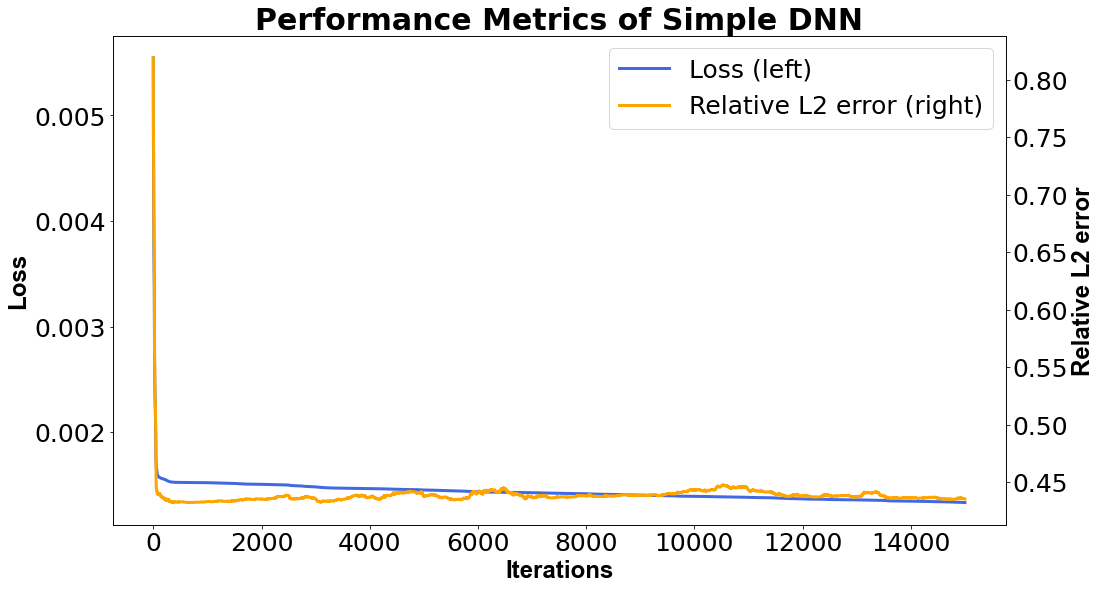

In [15]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Simple DNN", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [16]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.01479597382073873
MSE =  0.001597497450162775
RMSE =  0.03996870588551467
L2 relative error = 0.40430621983455006
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

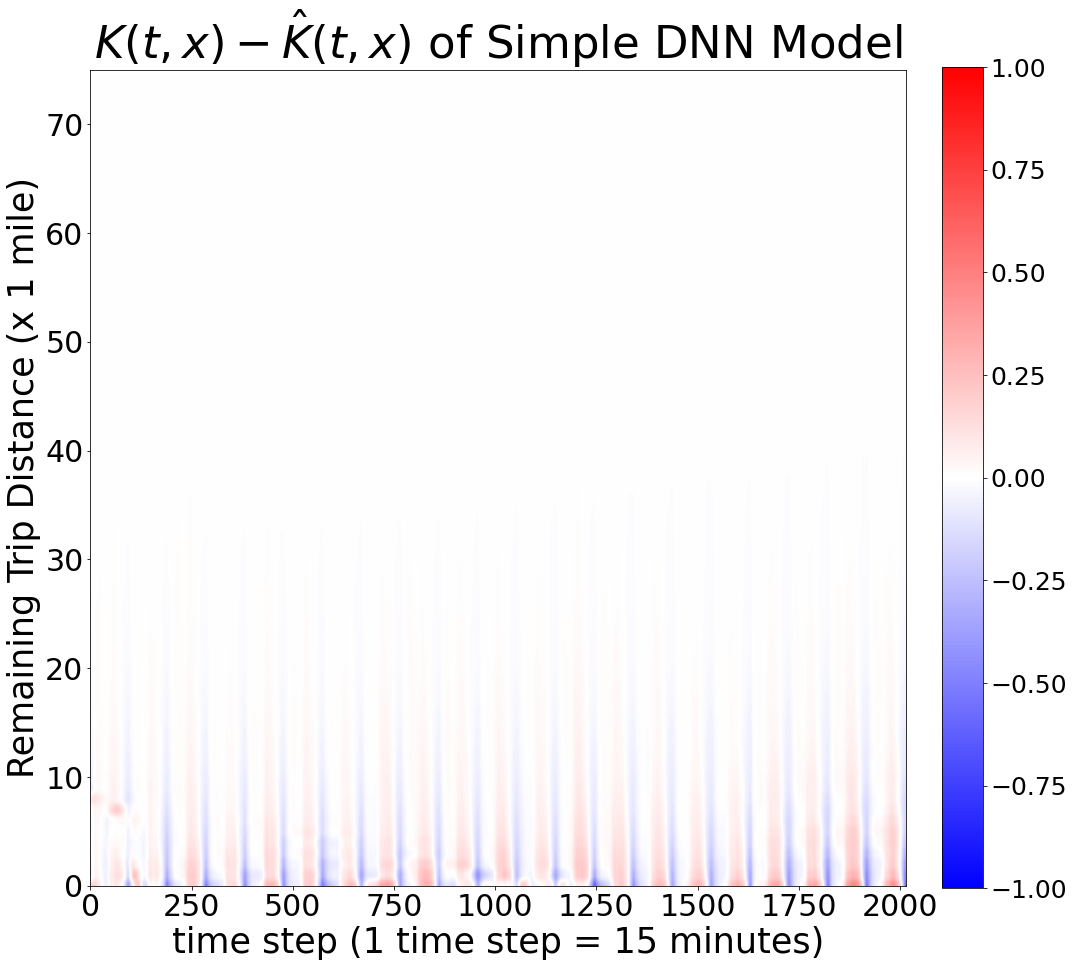

In [17]:
K_array = np.array(u_pred)
K_array = usol - K_array

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

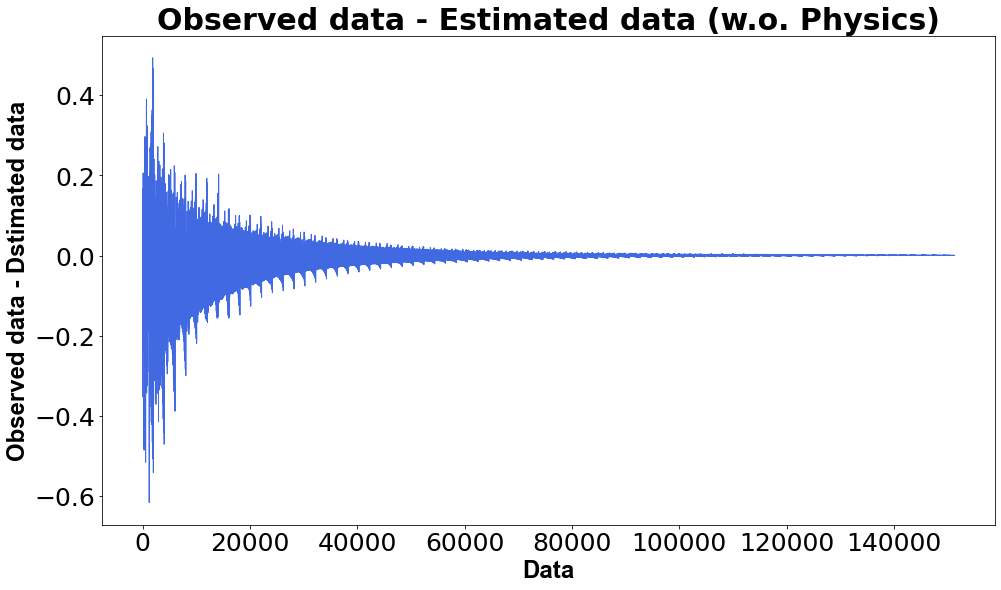

In [18]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data (w.o. Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Dstimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

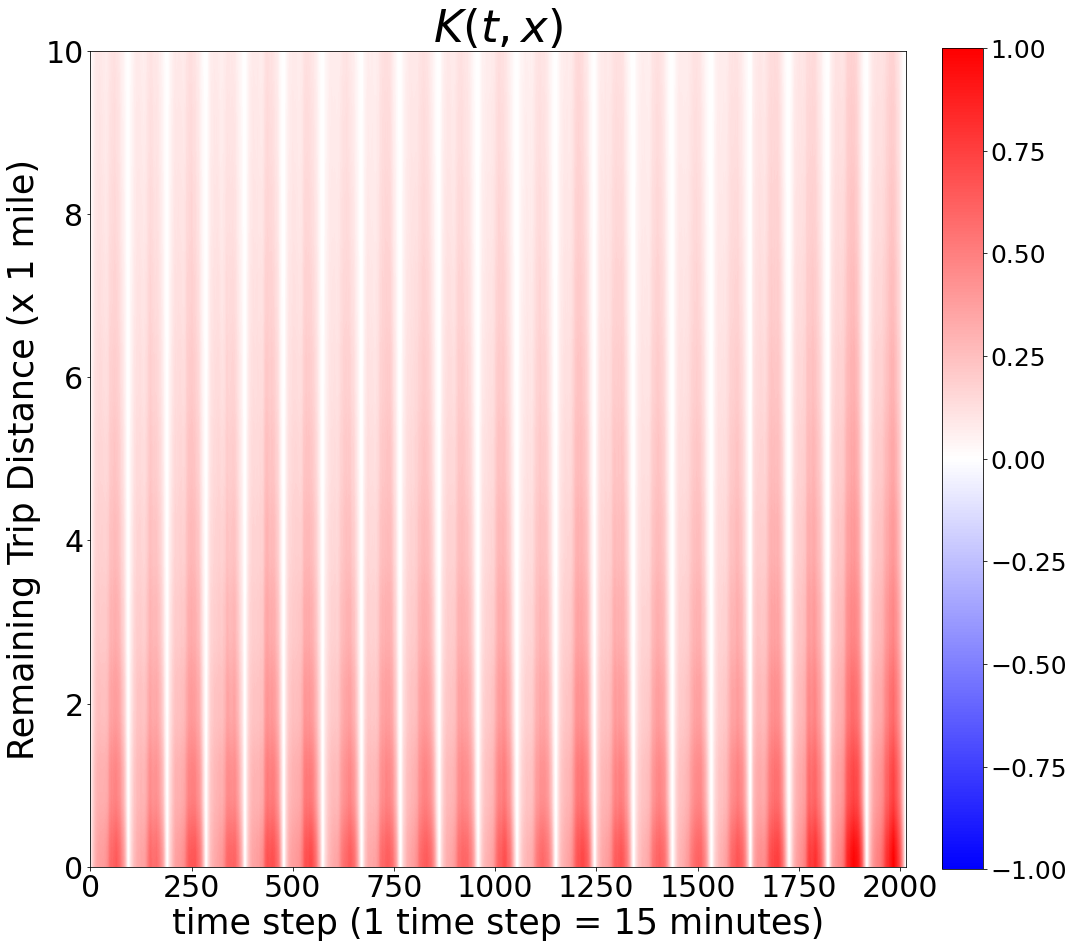

In [19]:
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(usol.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,10])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)$', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)